In [7]:
import covidcast
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

%cd ../code
from model import Model, ModelDiff

%cd ../notebooks

/home/xiavatar/Desktop/covidcast_latest/covidcast-nowcast/conv_models/code
/home/xiavatar/Desktop/covidcast_latest/covidcast-nowcast/conv_models/notebooks


In [2]:
#Load data
start_date = datetime(2020, 10, 15)
end_date = datetime(2020, 12, 15)
    
X_df = covidcast.signal(
        'fb-survey', 
        'smoothed_cli',
        start_date, end_date,
        geo_type='state')

Y_df = covidcast.signal(
        'indicator-combination',
        'confirmed_7dav_incidence_num',
        start_date, end_date,
        geo_type='state')

In [3]:
#Process data for use in Tensorflow
states = ['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'fl', 'ga',
       'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me',
       'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm',
       'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn',
       'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']

df = X_df.sort_values(['geo_value', 'time_value'])
df = df[df['geo_value'].isin(states)]
X = pd.pivot_table(df,index='geo_value',columns=df.groupby(['geo_value']).cumcount().add(1), values='value').values
X = tf.transpose(X, perm=[1,0])
X = tf.expand_dims(X,axis=0) #shape=(1,time series values, number of geo_values)
X = tf.cast(X, dtype=tf.float32)

df = Y_df.sort_values(['geo_value', 'time_value'])
df = df[df['geo_value'].isin(states)]
Y = pd.pivot_table(df,index='geo_value',columns=df.groupby(['geo_value']).cumcount().add(1), values='value').values
Y = tf.transpose(Y, perm=[1,0])
Y = tf.expand_dims(Y,axis=0) #shape=(1, time series values, number of geo_values)
Y = tf.cast(Y, dtype=tf.float32)

In [8]:
#Initialize model without filter bank

#You can apply constraints directly to layers by setting
#the kernel_constraints parameter for a specific layer
#
#https://www.tensorflow.org/api_docs/python/tf/keras/constraints

#You can also apply losses directly on the weights of a layer
#by setting the kernel_regularizer parameter
#
#https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
p = 30
m = X.shape[2] #number of geo_values
kernel_constraint = tf.keras.constraints.NonNeg()
kernel_regularizer = None 
lr = 1

model_a = Model(
    p = p, 
    m = m,
    kernel_constraint = kernel_constraint,
    kernel_regularizer = kernel_regularizer,
)
optimizer = tf.keras.optimizers.Adam(lr = lr)

def MSE(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
loss = MSE

#This just monitors the specified quantity
#and creates a checkpoint when the monitored quantity is 
#lower than the previous recorded value

MODEL_A_PATH = "model_a.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_A_PATH,
    verbose = 0,
    monitor = "MSE",
    mode = 'min',
    save_best_only = True,
    save_weights_only = True
)
callbacks = [
    checkpoint_callback,
]

model_a.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [loss],
)

In [9]:
#Training
hist = model_a.fit(
    x = X,
    y = Y,
    callbacks = callbacks,
   epochs = 1000,
)

Epoch 1/1000
1/1 [==============================] - 0s 30ms/step - MSE: 15581024.0000
Epoch 2/1000
1/1 [==============================] - 0s 27ms/step - MSE: 15437140.0000
Epoch 3/1000
1/1 [==============================] - 0s 29ms/step - MSE: 15295023.0000
Epoch 4/1000
1/1 [==============================] - 0s 28ms/step - MSE: 15154703.0000
Epoch 5/1000
1/1 [==============================] - 0s 28ms/step - MSE: 15016202.0000
Epoch 6/1000
1/1 [==============================] - 0s 29ms/step - MSE: 14879538.0000
Epoch 7/1000
1/1 [==============================] - 0s 29ms/step - MSE: 14744725.0000
Epoch 8/1000
1/1 [==============================] - 0s 28ms/step - MSE: 14611770.0000
Epoch 9/1000
1/1 [==============================] - 0s 30ms/step - MSE: 14480673.0000
Epoch 10/1000
1/1 [==============================] - 0s 26ms/step - MSE: 14351430.0000
Epoch 11/1000
1/1 [==============================] - 0s 27ms/step - MSE: 14224023.0000
Epoch 12/1000
1/1 [==============================] -

1/1 [==============================] - 0s 27ms/step - MSE: 7668510.0000
Epoch 96/1000
1/1 [==============================] - 0s 28ms/step - MSE: 7621183.0000
Epoch 97/1000
1/1 [==============================] - 0s 29ms/step - MSE: 7574295.5000
Epoch 98/1000
1/1 [==============================] - 0s 28ms/step - MSE: 7527843.0000
Epoch 99/1000
1/1 [==============================] - 0s 27ms/step - MSE: 7481819.0000
Epoch 100/1000
1/1 [==============================] - 0s 28ms/step - MSE: 7436219.5000
Epoch 101/1000
1/1 [==============================] - 0s 27ms/step - MSE: 7391038.5000
Epoch 102/1000
1/1 [==============================] - 0s 27ms/step - MSE: 7346270.0000
Epoch 103/1000
1/1 [==============================] - 0s 26ms/step - MSE: 7301910.0000
Epoch 104/1000
1/1 [==============================] - 0s 27ms/step - MSE: 7257952.0000
Epoch 105/1000
1/1 [==============================] - 0s 26ms/step - MSE: 7214394.5000
Epoch 106/1000
1/1 [==============================] - 0s 27ms/

1/1 [==============================] - 0s 26ms/step - MSE: 4611103.5000
Epoch 190/1000
1/1 [==============================] - 0s 27ms/step - MSE: 4589419.0000
Epoch 191/1000
1/1 [==============================] - 0s 27ms/step - MSE: 4567896.0000
Epoch 192/1000
1/1 [==============================] - 0s 26ms/step - MSE: 4546532.5000
Epoch 193/1000
1/1 [==============================] - 0s 28ms/step - MSE: 4525327.0000
Epoch 194/1000
1/1 [==============================] - 0s 27ms/step - MSE: 4504276.5000
Epoch 195/1000
1/1 [==============================] - 0s 27ms/step - MSE: 4483382.5000
Epoch 196/1000
1/1 [==============================] - 0s 32ms/step - MSE: 4462641.5000
Epoch 197/1000
1/1 [==============================] - 0s 34ms/step - MSE: 4442053.0000
Epoch 198/1000
1/1 [==============================] - 0s 32ms/step - MSE: 4421614.5000
Epoch 199/1000
1/1 [==============================] - 0s 29ms/step - MSE: 4401326.0000
Epoch 200/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 30ms/step - MSE: 3115307.0000
Epoch 284/1000
1/1 [==============================] - 0s 30ms/step - MSE: 3103887.2500
Epoch 285/1000
1/1 [==============================] - 0s 27ms/step - MSE: 3092538.7500
Epoch 286/1000
1/1 [==============================] - 0s 28ms/step - MSE: 3081261.0000
Epoch 287/1000
1/1 [==============================] - 0s 27ms/step - MSE: 3070052.5000
Epoch 288/1000
1/1 [==============================] - 0s 27ms/step - MSE: 3058913.2500
Epoch 289/1000
1/1 [==============================] - 0s 28ms/step - MSE: 3047843.5000
Epoch 290/1000
1/1 [==============================] - 0s 27ms/step - MSE: 3036841.5000
Epoch 291/1000
1/1 [==============================] - 0s 28ms/step - MSE: 3025907.0000
Epoch 292/1000
1/1 [==============================] - 0s 30ms/step - MSE: 3015039.7500
Epoch 293/1000
1/1 [==============================] - 0s 28ms/step - MSE: 3004239.5000
Epoch 294/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 26ms/step - MSE: 2289947.5000
Epoch 378/1000
1/1 [==============================] - 0s 27ms/step - MSE: 2283287.7500
Epoch 379/1000
1/1 [==============================] - 0s 27ms/step - MSE: 2276662.2500
Epoch 380/1000
1/1 [==============================] - 0s 27ms/step - MSE: 2270071.0000
Epoch 381/1000
1/1 [==============================] - 0s 27ms/step - MSE: 2263514.0000
Epoch 382/1000
1/1 [==============================] - 0s 27ms/step - MSE: 2256990.7500
Epoch 383/1000
1/1 [==============================] - 0s 27ms/step - MSE: 2250501.0000
Epoch 384/1000
1/1 [==============================] - 0s 27ms/step - MSE: 2244044.0000
Epoch 385/1000
1/1 [==============================] - 0s 27ms/step - MSE: 2237620.2500
Epoch 386/1000
1/1 [==============================] - 0s 27ms/step - MSE: 2231230.0000
Epoch 387/1000
1/1 [==============================] - 0s 29ms/step - MSE: 2224873.7500
Epoch 388/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 27ms/step - MSE: 1786869.3750
Epoch 472/1000
1/1 [==============================] - 0s 26ms/step - MSE: 1782595.8750
Epoch 473/1000
1/1 [==============================] - 0s 26ms/step - MSE: 1778340.5000
Epoch 474/1000
1/1 [==============================] - 0s 26ms/step - MSE: 1774103.0000
Epoch 475/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1769883.6250
Epoch 476/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1765681.7500
Epoch 477/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1761497.5000
Epoch 478/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1757331.3750
Epoch 479/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1753182.1250
Epoch 480/1000
1/1 [==============================] - 0s 26ms/step - MSE: 1749050.6250
Epoch 481/1000
1/1 [==============================] - 0s 26ms/step - MSE: 1744936.5000
Epoch 482/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 26ms/step - MSE: 1452063.3750
Epoch 566/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1449114.6250
Epoch 567/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1446176.7500
Epoch 568/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1443249.3750
Epoch 569/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1440333.0000
Epoch 570/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1437427.2500
Epoch 571/1000
1/1 [==============================] - 0s 87ms/step - MSE: 1434532.1250
Epoch 572/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1431647.7500
Epoch 573/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1428774.3750
Epoch 574/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1425911.2500
Epoch 575/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1423058.6250
Epoch 576/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 26ms/step - MSE: 1216605.3750
Epoch 660/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1214498.3750
Epoch 661/1000
1/1 [==============================] - 0s 29ms/step - MSE: 1212399.0000
Epoch 662/1000
1/1 [==============================] - 0s 26ms/step - MSE: 1210307.2500
Epoch 663/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1208222.6250
Epoch 664/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1206145.1250
Epoch 665/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1204074.7500
Epoch 666/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1202011.7500
Epoch 667/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1199956.0000
Epoch 668/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1197907.2500
Epoch 669/1000
1/1 [==============================] - 0s 26ms/step - MSE: 1195865.8750
Epoch 670/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 27ms/step - MSE: 1047470.0625
Epoch 754/1000
1/1 [==============================] - 0s 26ms/step - MSE: 1045953.0000
Epoch 755/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1044441.0000
Epoch 756/1000
1/1 [==============================] - 0s 30ms/step - MSE: 1042934.4375
Epoch 757/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1041433.1250
Epoch 758/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1039936.7500
Epoch 759/1000
1/1 [==============================] - 0s 30ms/step - MSE: 1038445.8125
Epoch 760/1000
1/1 [==============================] - 0s 29ms/step - MSE: 1036960.0625
Epoch 761/1000
1/1 [==============================] - 0s 30ms/step - MSE: 1035479.4375
Epoch 762/1000
1/1 [==============================] - 0s 29ms/step - MSE: 1034004.0625
Epoch 763/1000
1/1 [==============================] - 0s 29ms/step - MSE: 1032534.3750
Epoch 764/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 28ms/step - MSE: 924904.6250
Epoch 849/1000
1/1 [==============================] - 0s 27ms/step - MSE: 923821.4375
Epoch 850/1000
1/1 [==============================] - 0s 28ms/step - MSE: 922742.0000
Epoch 851/1000
1/1 [==============================] - 0s 26ms/step - MSE: 921666.5625
Epoch 852/1000
1/1 [==============================] - 0s 26ms/step - MSE: 920596.2500
Epoch 853/1000
1/1 [==============================] - 0s 27ms/step - MSE: 919530.1250
Epoch 854/1000
1/1 [==============================] - 0s 90ms/step - MSE: 918467.5625
Epoch 855/1000
1/1 [==============================] - 0s 28ms/step - MSE: 917408.8750
Epoch 856/1000
1/1 [==============================] - 0s 27ms/step - MSE: 916353.8125
Epoch 857/1000
1/1 [==============================] - 0s 27ms/step - MSE: 915302.5625
Epoch 858/1000
1/1 [==============================] - 0s 28ms/step - MSE: 914255.0000
Epoch 859/1000
1/1 [==============================] - 0s 28ms/step - 

1/1 [==============================] - 0s 26ms/step - MSE: 837822.9375
Epoch 944/1000
1/1 [==============================] - 0s 27ms/step - MSE: 837058.3750
Epoch 945/1000
1/1 [==============================] - 0s 28ms/step - MSE: 836296.5625
Epoch 946/1000
1/1 [==============================] - 0s 27ms/step - MSE: 835537.5625
Epoch 947/1000
1/1 [==============================] - 0s 28ms/step - MSE: 834781.3125
Epoch 948/1000
1/1 [==============================] - 0s 26ms/step - MSE: 834027.6875
Epoch 949/1000
1/1 [==============================] - 0s 27ms/step - MSE: 833276.8750
Epoch 950/1000
1/1 [==============================] - 0s 27ms/step - MSE: 832528.6875
Epoch 951/1000
1/1 [==============================] - 0s 27ms/step - MSE: 831783.2500
Epoch 952/1000
1/1 [==============================] - 0s 27ms/step - MSE: 831040.5000
Epoch 953/1000
1/1 [==============================] - 0s 27ms/step - MSE: 830300.2500
Epoch 954/1000
1/1 [==============================] - 0s 27ms/step - 

In [30]:
#Initialize model with filter bank [1,0,0,0,...], [0,1,0,0,...], [0,0,1,0,...]

#You can apply constraints directly to layers by setting
#the kernel_constraints parameter for a specific layer
#
#https://www.tensorflow.org/api_docs/python/tf/keras/constraints

#You can also apply losses directly on the weights of a layer
#by setting the kernel_regularizer parameter
#
#https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
p = 30
m = X.shape[2] #number of geo_values
kernel_constraint = tf.keras.constraints.NonNeg()
kernel_regularizer = None 
filter_bank = [[1. if i == j else 0. for j in range(30)] for i in range(30)]
lr = 0.2

model_b = ModelDiff(
    p = p, 
    m = m,
    filter_bank=filter_bank,
    kernel_constraint = kernel_constraint,
    kernel_regularizer = kernel_regularizer,
    lam = 1,
)
optimizer = tf.keras.optimizers.Adam(lr = lr)

def MSE(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
loss = MSE

#This just monitors the specified quantity
#and creates a checkpoint when the monitored quantity is 
#lower than the previous recorded value

MODEL_B_PATH = "model_b.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_B_PATH,
    verbose = 0,
    monitor = "MSE",
    mode = 'min',
    save_best_only = True,
    save_weights_only = True
)
callbacks = [
    checkpoint_callback,
]

model_b.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [loss],
)

In [31]:
#Training
hist = model_b.fit(
    x = X,
    y = Y,
    callbacks = callbacks,
    epochs = 2000,
)

Epoch 1/2000
1/1 [==============================] - 0s 28ms/step - MSE: 15581347.0000
Epoch 2/2000
1/1 [==============================] - 0s 28ms/step - MSE: 15551279.0000
Epoch 3/2000
1/1 [==============================] - 0s 35ms/step - MSE: 15522437.0000
Epoch 4/2000
1/1 [==============================] - 0s 28ms/step - MSE: 15493664.0000
Epoch 5/2000
1/1 [==============================] - 0s 28ms/step - MSE: 15464966.0000
Epoch 6/2000
1/1 [==============================] - 0s 29ms/step - MSE: 15436342.0000
Epoch 7/2000
1/1 [==============================] - 0s 28ms/step - MSE: 15407792.0000
Epoch 8/2000
1/1 [==============================] - 0s 29ms/step - MSE: 15379319.0000
Epoch 9/2000
1/1 [==============================] - 0s 29ms/step - MSE: 15350920.0000
Epoch 10/2000
1/1 [==============================] - 0s 29ms/step - MSE: 15322601.0000
Epoch 11/2000
1/1 [==============================] - 0s 28ms/step - MSE: 15294362.0000
Epoch 12/2000
1/1 [==============================] -

1/1 [==============================] - 0s 29ms/step - MSE: 13213207.0000
Epoch 96/2000
1/1 [==============================] - 0s 31ms/step - MSE: 13191490.0000
Epoch 97/2000
1/1 [==============================] - 0s 28ms/step - MSE: 13169836.0000
Epoch 98/2000
1/1 [==============================] - 0s 28ms/step - MSE: 13148239.0000
Epoch 99/2000
1/1 [==============================] - 0s 28ms/step - MSE: 13126702.0000
Epoch 100/2000
1/1 [==============================] - 0s 28ms/step - MSE: 13105225.0000
Epoch 101/2000
1/1 [==============================] - 0s 27ms/step - MSE: 13083807.0000
Epoch 102/2000
1/1 [==============================] - 0s 28ms/step - MSE: 13062447.0000
Epoch 103/2000
1/1 [==============================] - 0s 29ms/step - MSE: 13041146.0000
Epoch 104/2000
1/1 [==============================] - 0s 29ms/step - MSE: 13019901.0000
Epoch 105/2000
1/1 [==============================] - 0s 28ms/step - MSE: 12998717.0000
Epoch 106/2000
1/1 [==============================]

1/1 [==============================] - 0s 28ms/step - MSE: 11417866.0000
Epoch 189/2000
1/1 [==============================] - 0s 28ms/step - MSE: 11400724.0000
Epoch 190/2000
1/1 [==============================] - 0s 28ms/step - MSE: 11383623.0000
Epoch 191/2000
1/1 [==============================] - 0s 28ms/step - MSE: 11366564.0000
Epoch 192/2000
1/1 [==============================] - 0s 28ms/step - MSE: 11349543.0000
Epoch 193/2000
1/1 [==============================] - 0s 28ms/step - MSE: 11332564.0000
Epoch 194/2000
1/1 [==============================] - 0s 28ms/step - MSE: 11315625.0000
Epoch 195/2000
1/1 [==============================] - 0s 28ms/step - MSE: 11298726.0000
Epoch 196/2000
1/1 [==============================] - 0s 28ms/step - MSE: 11281865.0000
Epoch 197/2000
1/1 [==============================] - 0s 28ms/step - MSE: 11265045.0000
Epoch 198/2000
1/1 [==============================] - 0s 28ms/step - MSE: 11248265.0000
Epoch 199/2000
1/1 [===========================

1/1 [==============================] - 0s 27ms/step - MSE: 9980580.0000
Epoch 282/2000
1/1 [==============================] - 0s 28ms/step - MSE: 9966678.0000
Epoch 283/2000
1/1 [==============================] - 0s 27ms/step - MSE: 9952804.0000
Epoch 284/2000
1/1 [==============================] - 0s 29ms/step - MSE: 9938962.0000
Epoch 285/2000
1/1 [==============================] - 0s 28ms/step - MSE: 9925148.0000
Epoch 286/2000
1/1 [==============================] - 0s 28ms/step - MSE: 9911363.0000
Epoch 287/2000
1/1 [==============================] - 0s 27ms/step - MSE: 9897609.0000
Epoch 288/2000
1/1 [==============================] - 0s 27ms/step - MSE: 9883885.0000
Epoch 289/2000
1/1 [==============================] - 0s 29ms/step - MSE: 9870188.0000
Epoch 290/2000
1/1 [==============================] - 0s 28ms/step - MSE: 9856521.0000
Epoch 291/2000
1/1 [==============================] - 0s 28ms/step - MSE: 9842882.0000
Epoch 292/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 29ms/step - MSE: 8792026.0000
Epoch 376/2000
1/1 [==============================] - 0s 28ms/step - MSE: 8780550.0000
Epoch 377/2000
1/1 [==============================] - 0s 27ms/step - MSE: 8769098.0000
Epoch 378/2000
1/1 [==============================] - 0s 27ms/step - MSE: 8757667.0000
Epoch 379/2000
1/1 [==============================] - 0s 28ms/step - MSE: 8746258.0000
Epoch 380/2000
1/1 [==============================] - 0s 28ms/step - MSE: 8734872.0000
Epoch 381/2000
1/1 [==============================] - 0s 28ms/step - MSE: 8723508.0000
Epoch 382/2000
1/1 [==============================] - 0s 28ms/step - MSE: 8712166.0000
Epoch 383/2000
1/1 [==============================] - 0s 28ms/step - MSE: 8700845.0000
Epoch 384/2000
1/1 [==============================] - 0s 26ms/step - MSE: 8689546.0000
Epoch 385/2000
1/1 [==============================] - 0s 28ms/step - MSE: 8678271.0000
Epoch 386/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 30ms/step - MSE: 7803250.5000
Epoch 470/2000
1/1 [==============================] - 0s 29ms/step - MSE: 7793631.0000
Epoch 471/2000
1/1 [==============================] - 0s 29ms/step - MSE: 7784027.0000
Epoch 472/2000
1/1 [==============================] - 0s 29ms/step - MSE: 7774442.0000
Epoch 473/2000
1/1 [==============================] - 0s 29ms/step - MSE: 7764873.0000
Epoch 474/2000
1/1 [==============================] - 0s 30ms/step - MSE: 7755322.0000
Epoch 475/2000
1/1 [==============================] - 0s 29ms/step - MSE: 7745788.5000
Epoch 476/2000
1/1 [==============================] - 0s 30ms/step - MSE: 7736271.0000
Epoch 477/2000
1/1 [==============================] - 0s 27ms/step - MSE: 7726771.5000
Epoch 478/2000
1/1 [==============================] - 0s 27ms/step - MSE: 7717289.0000
Epoch 479/2000
1/1 [==============================] - 0s 27ms/step - MSE: 7707823.0000
Epoch 480/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 28ms/step - MSE: 6969525.5000
Epoch 564/2000
1/1 [==============================] - 0s 28ms/step - MSE: 6961368.5000
Epoch 565/2000
1/1 [==============================] - 0s 27ms/step - MSE: 6953225.5000
Epoch 566/2000
1/1 [==============================] - 0s 27ms/step - MSE: 6945096.5000
Epoch 567/2000
1/1 [==============================] - 0s 28ms/step - MSE: 6936981.0000
Epoch 568/2000
1/1 [==============================] - 0s 28ms/step - MSE: 6928879.5000
Epoch 569/2000
1/1 [==============================] - 0s 27ms/step - MSE: 6920792.0000
Epoch 570/2000
1/1 [==============================] - 0s 27ms/step - MSE: 6912718.0000
Epoch 571/2000
1/1 [==============================] - 0s 27ms/step - MSE: 6904657.5000
Epoch 572/2000
1/1 [==============================] - 0s 27ms/step - MSE: 6896611.5000
Epoch 573/2000
1/1 [==============================] - 0s 27ms/step - MSE: 6888578.0000
Epoch 574/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 27ms/step - MSE: 6259718.5000
Epoch 658/2000
1/1 [==============================] - 0s 28ms/step - MSE: 6252746.0000
Epoch 659/2000
1/1 [==============================] - 0s 30ms/step - MSE: 6245785.0000
Epoch 660/2000
1/1 [==============================] - 0s 29ms/step - MSE: 6238835.5000
Epoch 661/2000
1/1 [==============================] - 0s 28ms/step - MSE: 6231897.0000
Epoch 662/2000
1/1 [==============================] - 0s 28ms/step - MSE: 6224970.0000
Epoch 663/2000
1/1 [==============================] - 0s 29ms/step - MSE: 6218054.5000
Epoch 664/2000
1/1 [==============================] - 0s 28ms/step - MSE: 6211150.0000
Epoch 665/2000
1/1 [==============================] - 0s 28ms/step - MSE: 6204256.0000
Epoch 666/2000
1/1 [==============================] - 0s 27ms/step - MSE: 6197374.0000
Epoch 667/2000
1/1 [==============================] - 0s 28ms/step - MSE: 6190503.5000
Epoch 668/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 27ms/step - MSE: 5651073.0000
Epoch 752/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5645075.5000
Epoch 753/2000
1/1 [==============================] - 0s 27ms/step - MSE: 5639087.5000
Epoch 754/2000
1/1 [==============================] - 0s 27ms/step - MSE: 5633108.5000
Epoch 755/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5627139.0000
Epoch 756/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5621178.5000
Epoch 757/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5615227.0000
Epoch 758/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5609285.5000
Epoch 759/2000
1/1 [==============================] - 0s 27ms/step - MSE: 5603354.0000
Epoch 760/2000
1/1 [==============================] - 0s 27ms/step - MSE: 5597430.5000
Epoch 761/2000
1/1 [==============================] - 0s 30ms/step - MSE: 5591517.0000
Epoch 762/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 28ms/step - MSE: 5126092.0000
Epoch 846/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5120904.0000
Epoch 847/2000
1/1 [==============================] - 0s 30ms/step - MSE: 5115724.0000
Epoch 848/2000
1/1 [==============================] - 0s 30ms/step - MSE: 5110552.0000
Epoch 849/2000
1/1 [==============================] - 0s 30ms/step - MSE: 5105388.0000
Epoch 850/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5100231.0000
Epoch 851/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5095082.5000
Epoch 852/2000
1/1 [==============================] - 0s 27ms/step - MSE: 5089941.5000
Epoch 853/2000
1/1 [==============================] - 0s 27ms/step - MSE: 5084808.0000
Epoch 854/2000
1/1 [==============================] - 0s 29ms/step - MSE: 5079683.0000
Epoch 855/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5074565.5000
Epoch 856/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 28ms/step - MSE: 4670873.5000
Epoch 940/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4666363.5000
Epoch 941/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4661860.0000
Epoch 942/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4657362.5000
Epoch 943/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4652872.0000
Epoch 944/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4648388.5000
Epoch 945/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4643911.0000
Epoch 946/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4639440.0000
Epoch 947/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4634976.0000
Epoch 948/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4630518.0000
Epoch 949/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4626066.5000
Epoch 950/2000
1/1 [==============================] - 0s 2

Epoch 1033/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4274194.0000
Epoch 1034/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4270254.5000
Epoch 1035/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4266320.5000
Epoch 1036/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4262391.5000
Epoch 1037/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4258468.0000
Epoch 1038/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4254550.5000
Epoch 1039/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4250638.5000
Epoch 1040/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4246731.5000
Epoch 1041/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4242831.0000
Epoch 1042/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4238935.0000
Epoch 1043/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4235045.5000
Epoch 1044/2000
1/1 [===========

1/1 [==============================] - 0s 29ms/step - MSE: 3930388.5000
Epoch 1127/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3926926.7500
Epoch 1128/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3923469.5000
Epoch 1129/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3920017.7500
Epoch 1130/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3916570.0000
Epoch 1131/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3913127.7500
Epoch 1132/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3909689.5000
Epoch 1133/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3906256.5000
Epoch 1134/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3902827.7500
Epoch 1135/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3899404.0000
Epoch 1136/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3895984.7500
Epoch 1137/2000
1/1 [===========================

1/1 [==============================] - 0s 27ms/step - MSE: 3627725.5000
Epoch 1220/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3624672.5000
Epoch 1221/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3621623.0000
Epoch 1222/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3618578.2500
Epoch 1223/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3615537.2500
Epoch 1224/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3612500.5000
Epoch 1225/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3609467.5000
Epoch 1226/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3606438.5000
Epoch 1227/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3603413.7500
Epoch 1228/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3600393.0000
Epoch 1229/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3597376.0000
Epoch 1230/2000
1/1 [===========================

1/1 [==============================] - 0s 27ms/step - MSE: 3360336.5000
Epoch 1313/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3357634.2500
Epoch 1314/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3354935.2500
Epoch 1315/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3352239.7500
Epoch 1316/2000
1/1 [==============================] - 0s 32ms/step - MSE: 3349548.0000
Epoch 1317/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3346859.5000
Epoch 1318/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3344174.2500
Epoch 1319/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3341492.7500
Epoch 1320/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3338814.7500
Epoch 1321/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3336139.7500
Epoch 1322/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3333468.7500
Epoch 1323/2000
1/1 [===========================

1/1 [==============================] - 0s 29ms/step - MSE: 3123235.7500
Epoch 1406/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3120835.0000
Epoch 1407/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3118437.5000
Epoch 1408/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3116043.0000
Epoch 1409/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3113651.0000
Epoch 1410/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3111262.7500
Epoch 1411/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3108877.2500
Epoch 1412/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3106494.2500
Epoch 1413/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3104114.5000
Epoch 1414/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3101738.2500
Epoch 1415/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3099364.5000
Epoch 1416/2000
1/1 [===========================

1/1 [==============================] - 0s 30ms/step - MSE: 2912268.5000
Epoch 1499/2000
1/1 [==============================] - 0s 31ms/step - MSE: 2910128.5000
Epoch 1500/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2907991.2500
Epoch 1501/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2905857.0000
Epoch 1502/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2903724.7500
Epoch 1503/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2901595.5000
Epoch 1504/2000
1/1 [==============================] - 0s 35ms/step - MSE: 2899468.5000
Epoch 1505/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2897344.5000
Epoch 1506/2000
1/1 [==============================] - 0s 32ms/step - MSE: 2895223.0000
Epoch 1507/2000
1/1 [==============================] - 0s 31ms/step - MSE: 2893103.5000
Epoch 1508/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2890987.2500
Epoch 1509/2000
1/1 [===========================

1/1 [==============================] - 0s 28ms/step - MSE: 2723920.2500
Epoch 1592/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2722006.5000
Epoch 1593/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2720095.2500
Epoch 1594/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2718185.7500
Epoch 1595/2000
1/1 [==============================] - 0s 27ms/step - MSE: 2716279.0000
Epoch 1596/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2714374.5000
Epoch 1597/2000
1/1 [==============================] - 0s 31ms/step - MSE: 2712472.0000
Epoch 1598/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2710572.0000
Epoch 1599/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2708674.0000
Epoch 1600/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2706778.2500
Epoch 1601/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2704884.7500
Epoch 1602/2000
1/1 [===========================

1/1 [==============================] - 0s 30ms/step - MSE: 2555189.2500
Epoch 1685/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2553471.7500
Epoch 1686/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2551756.5000
Epoch 1687/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2550042.7500
Epoch 1688/2000
1/1 [==============================] - 0s 34ms/step - MSE: 2548331.2500
Epoch 1689/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2546621.7500
Epoch 1690/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2544914.2500
Epoch 1691/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2543208.5000
Epoch 1692/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2541504.5000
Epoch 1693/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2539803.0000
Epoch 1694/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2538103.0000
Epoch 1695/2000
1/1 [===========================

1/1 [==============================] - 0s 29ms/step - MSE: 2403494.2500
Epoch 1778/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2401947.0000
Epoch 1779/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2400402.0000
Epoch 1780/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2398858.5000
Epoch 1781/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2397316.5000
Epoch 1782/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2395776.7500
Epoch 1783/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2394238.2500
Epoch 1784/2000
1/1 [==============================] - 0s 27ms/step - MSE: 2392701.5000
Epoch 1785/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2391166.5000
Epoch 1786/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2389633.2500
Epoch 1787/2000
1/1 [==============================] - 0s 32ms/step - MSE: 2388101.5000
Epoch 1788/2000
1/1 [===========================

1/1 [==============================] - 0s 29ms/step - MSE: 2266610.5000
Epoch 1871/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2265211.7500
Epoch 1872/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2263814.7500
Epoch 1873/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2262419.2500
Epoch 1874/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2261024.7500
Epoch 1875/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2259632.0000
Epoch 1876/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2258240.7500
Epoch 1877/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2256851.0000
Epoch 1878/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2255462.5000
Epoch 1879/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2254075.7500
Epoch 1880/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2252690.2500
Epoch 1881/2000
1/1 [===========================

1/1 [==============================] - 0s 28ms/step - MSE: 2142603.0000
Epoch 1964/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2141333.2500
Epoch 1965/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2140064.7500
Epoch 1966/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2138797.5000
Epoch 1967/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2137531.5000
Epoch 1968/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2136267.2500
Epoch 1969/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2135004.0000
Epoch 1970/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2133742.2500
Epoch 1971/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2132481.2500
Epoch 1972/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2131222.2500
Epoch 1973/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2129964.0000
Epoch 1974/2000
1/1 [===========================

In [36]:
#Initialize model with filter bank [1,1,0,0,...], [0,1,1,0,...], [0,0,1,1,...]

#You can apply constraints directly to layers by setting
#the kernel_constraints parameter for a specific layer
#
#https://www.tensorflow.org/api_docs/python/tf/keras/constraints

#You can also apply losses directly on the weights of a layer
#by setting the kernel_regularizer parameter
#
#https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
p = 30
m = X.shape[2] #number of geo_values
kernel_constraint = tf.keras.constraints.NonNeg()
kernel_regularizer = None 
filter_bank = [[1. if (j == i or j==(i+1)) else 0. for j in range(30)] for i in range(29)]
lr = 0.2

model_c = Model(
    p = p, 
    m = m,
    filter_bank=filter_bank,
    kernel_constraint = kernel_constraint,
    kernel_regularizer = kernel_regularizer,
    lam = 0.00001,
)
optimizer = tf.keras.optimizers.Adam(lr = lr)

def MSE(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
loss = MSE

#This just monitors the specified quantity
#and creates a checkpoint when the monitored quantity is 
#lower than the previous recorded value

MODEL_C_PATH = "model_c.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_C_PATH,
    verbose = 0,
    monitor = "MSE",
    mode = 'min',
    save_best_only = True,
    save_weights_only = True
)
callbacks = [
    checkpoint_callback,
]

model_c.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [loss],
)

In [37]:
#Training
hist = model_c.fit(
    x = X,
    y = Y,
    callbacks = callbacks,
    epochs = 2000,
)

Epoch 1/2000
1/1 [==============================] - 0s 30ms/step - MSE: 15584787.0000
Epoch 2/2000
1/1 [==============================] - 0s 28ms/step - MSE: 15525108.0000
Epoch 3/2000
1/1 [==============================] - 0s 30ms/step - MSE: 15469473.0000
Epoch 4/2000
1/1 [==============================] - 0s 28ms/step - MSE: 15414107.0000
Epoch 5/2000
1/1 [==============================] - 0s 30ms/step - MSE: 15359014.0000
Epoch 6/2000
1/1 [==============================] - 0s 29ms/step - MSE: 15304201.0000
Epoch 7/2000
1/1 [==============================] - 0s 27ms/step - MSE: 15249668.0000
Epoch 8/2000
1/1 [==============================] - 0s 30ms/step - MSE: 15195419.0000
Epoch 9/2000
1/1 [==============================] - 0s 29ms/step - MSE: 15141461.0000
Epoch 10/2000
1/1 [==============================] - 0s 28ms/step - MSE: 15087793.0000
Epoch 11/2000
1/1 [==============================] - 0s 28ms/step - MSE: 15034417.0000
Epoch 12/2000
1/1 [==============================] -

1/1 [==============================] - 0s 27ms/step - MSE: 11482647.0000
Epoch 96/2000
1/1 [==============================] - 0s 27ms/step - MSE: 11449101.0000
Epoch 97/2000
1/1 [==============================] - 0s 29ms/step - MSE: 11415718.0000
Epoch 98/2000
1/1 [==============================] - 0s 28ms/step - MSE: 11382497.0000
Epoch 99/2000
1/1 [==============================] - 0s 27ms/step - MSE: 11349435.0000
Epoch 100/2000
1/1 [==============================] - 0s 28ms/step - MSE: 11316532.0000
Epoch 101/2000
1/1 [==============================] - 0s 29ms/step - MSE: 11283785.0000
Epoch 102/2000
1/1 [==============================] - 0s 28ms/step - MSE: 11251197.0000
Epoch 103/2000
1/1 [==============================] - 0s 28ms/step - MSE: 11218763.0000
Epoch 104/2000
1/1 [==============================] - 0s 29ms/step - MSE: 11186484.0000
Epoch 105/2000
1/1 [==============================] - 0s 29ms/step - MSE: 11154358.0000
Epoch 106/2000
1/1 [==============================]

1/1 [==============================] - 0s 28ms/step - MSE: 8939147.0000
Epoch 189/2000
1/1 [==============================] - 0s 28ms/step - MSE: 8917063.0000
Epoch 190/2000
1/1 [==============================] - 0s 28ms/step - MSE: 8895073.0000
Epoch 191/2000
1/1 [==============================] - 0s 29ms/step - MSE: 8873175.0000
Epoch 192/2000
1/1 [==============================] - 0s 29ms/step - MSE: 8851369.0000
Epoch 193/2000
1/1 [==============================] - 0s 28ms/step - MSE: 8829655.0000
Epoch 194/2000
1/1 [==============================] - 0s 29ms/step - MSE: 8808033.0000
Epoch 195/2000
1/1 [==============================] - 0s 29ms/step - MSE: 8786501.0000
Epoch 196/2000
1/1 [==============================] - 0s 30ms/step - MSE: 8765061.0000
Epoch 197/2000
1/1 [==============================] - 0s 28ms/step - MSE: 8743711.0000
Epoch 198/2000
1/1 [==============================] - 0s 29ms/step - MSE: 8722450.0000
Epoch 199/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 28ms/step - MSE: 7217296.5000
Epoch 283/2000
1/1 [==============================] - 0s 27ms/step - MSE: 7202324.0000
Epoch 284/2000
1/1 [==============================] - 0s 28ms/step - MSE: 7187413.0000
Epoch 285/2000
1/1 [==============================] - 0s 28ms/step - MSE: 7172562.5000
Epoch 286/2000
1/1 [==============================] - 0s 28ms/step - MSE: 7157772.5000
Epoch 287/2000
1/1 [==============================] - 0s 27ms/step - MSE: 7143044.0000
Epoch 288/2000
1/1 [==============================] - 0s 28ms/step - MSE: 7128376.0000
Epoch 289/2000
1/1 [==============================] - 0s 27ms/step - MSE: 7113767.0000
Epoch 290/2000
1/1 [==============================] - 0s 28ms/step - MSE: 7099219.0000
Epoch 291/2000
1/1 [==============================] - 0s 28ms/step - MSE: 7084729.5000
Epoch 292/2000
1/1 [==============================] - 0s 27ms/step - MSE: 7070300.5000
Epoch 293/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 29ms/step - MSE: 6048744.0000
Epoch 377/2000
1/1 [==============================] - 0s 29ms/step - MSE: 6038618.5000
Epoch 378/2000
1/1 [==============================] - 0s 29ms/step - MSE: 6028534.5000
Epoch 379/2000
1/1 [==============================] - 0s 28ms/step - MSE: 6018494.5000
Epoch 380/2000
1/1 [==============================] - 0s 29ms/step - MSE: 6008496.5000
Epoch 381/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5998541.0000
Epoch 382/2000
1/1 [==============================] - 0s 29ms/step - MSE: 5988627.5000
Epoch 383/2000
1/1 [==============================] - 0s 29ms/step - MSE: 5978757.0000
Epoch 384/2000
1/1 [==============================] - 0s 31ms/step - MSE: 5968927.5000
Epoch 385/2000
1/1 [==============================] - 0s 29ms/step - MSE: 5959140.5000
Epoch 386/2000
1/1 [==============================] - 0s 29ms/step - MSE: 5949394.5000
Epoch 387/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 28ms/step - MSE: 5264776.0000
Epoch 471/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5258058.5000
Epoch 472/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5251372.5000
Epoch 473/2000
1/1 [==============================] - 0s 27ms/step - MSE: 5244715.5000
Epoch 474/2000
1/1 [==============================] - 0s 27ms/step - MSE: 5238089.5000
Epoch 475/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5231493.0000
Epoch 476/2000
1/1 [==============================] - 0s 27ms/step - MSE: 5224926.0000
Epoch 477/2000
1/1 [==============================] - 0s 27ms/step - MSE: 5218388.0000
Epoch 478/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5211881.0000
Epoch 479/2000
1/1 [==============================] - 0s 27ms/step - MSE: 5205402.5000
Epoch 480/2000
1/1 [==============================] - 0s 27ms/step - MSE: 5198953.5000
Epoch 481/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 27ms/step - MSE: 4751173.5000
Epoch 565/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4746844.0000
Epoch 566/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4742533.0000
Epoch 567/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4738244.5000
Epoch 568/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4733976.5000
Epoch 569/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4729728.0000
Epoch 570/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4725502.0000
Epoch 571/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4721295.5000
Epoch 572/2000
1/1 [==============================] - 0s 32ms/step - MSE: 4717109.5000
Epoch 573/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4712943.5000
Epoch 574/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4708798.5000
Epoch 575/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 35ms/step - MSE: 4425108.5000
Epoch 659/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4422412.5000
Epoch 660/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4419730.5000
Epoch 661/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4417063.0000
Epoch 662/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4414409.0000
Epoch 663/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4411769.0000
Epoch 664/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4409143.0000
Epoch 665/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4406530.5000
Epoch 666/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4403932.0000
Epoch 667/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4401347.0000
Epoch 668/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4398776.0000
Epoch 669/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 28ms/step - MSE: 4225727.5000
Epoch 753/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4224115.0000
Epoch 754/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4222512.0000
Epoch 755/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4220918.0000
Epoch 756/2000
1/1 [==============================] - 0s 26ms/step - MSE: 4219333.0000
Epoch 757/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4217757.5000
Epoch 758/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4216190.5000
Epoch 759/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4214632.5000
Epoch 760/2000
1/1 [==============================] - 0s 31ms/step - MSE: 4213084.0000
Epoch 761/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4211544.0000
Epoch 762/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4210012.0000
Epoch 763/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 27ms/step - MSE: 4108806.2500
Epoch 847/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4107883.7500
Epoch 848/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4106966.7500
Epoch 849/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4106055.7500
Epoch 850/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4105150.0000
Epoch 851/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4104250.2500
Epoch 852/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4103355.2500
Epoch 853/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4102466.7500
Epoch 854/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4101583.5000
Epoch 855/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4100705.7500
Epoch 856/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4099833.0000
Epoch 857/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 27ms/step - MSE: 4043256.0000
Epoch 941/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4042751.2500
Epoch 942/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4042250.5000
Epoch 943/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4041753.0000
Epoch 944/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4041259.0000
Epoch 945/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4040768.0000
Epoch 946/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4040280.5000
Epoch 947/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4039796.0000
Epoch 948/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4039315.0000
Epoch 949/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4038837.0000
Epoch 950/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4038362.7500
Epoch 951/2000
1/1 [==============================] - 0s 3

Epoch 1034/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4008166.2500
Epoch 1035/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4007903.2500
Epoch 1036/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4007642.2500
Epoch 1037/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4007383.0000
Epoch 1038/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4007125.7500
Epoch 1039/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4006870.0000
Epoch 1040/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4006616.7500
Epoch 1041/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4006365.0000
Epoch 1042/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4006115.0000
Epoch 1043/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4005866.5000
Epoch 1044/2000
1/1 [==============================] - 0s 27ms/step - MSE: 4005620.0000
Epoch 1045/2000
1/1 [===========

1/1 [==============================] - 0s 27ms/step - MSE: 3990370.7500
Epoch 1128/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3990238.7500
Epoch 1129/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3990107.7500
Epoch 1130/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3989977.7500
Epoch 1131/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3989848.5000
Epoch 1132/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3989720.0000
Epoch 1133/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3989593.2500
Epoch 1134/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3989467.2500
Epoch 1135/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3989341.7500
Epoch 1136/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3989217.2500
Epoch 1137/2000
1/1 [==============================] - 0s 32ms/step - MSE: 3989094.0000
Epoch 1138/2000
1/1 [===========================

1/1 [==============================] - 0s 29ms/step - MSE: 3981588.5000
Epoch 1221/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3981525.0000
Epoch 1222/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3981461.7500
Epoch 1223/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3981399.2500
Epoch 1224/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3981336.7500
Epoch 1225/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3981275.2500
Epoch 1226/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3981214.2500
Epoch 1227/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3981153.5000
Epoch 1228/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3981093.2500
Epoch 1229/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3981033.2500
Epoch 1230/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3980974.0000
Epoch 1231/2000
1/1 [===========================

1/1 [==============================] - 0s 30ms/step - MSE: 3977412.2500
Epoch 1314/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3977382.5000
Epoch 1315/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3977352.7500
Epoch 1316/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3977323.0000
Epoch 1317/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3977294.2500
Epoch 1318/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3977265.5000
Epoch 1319/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3977236.7500
Epoch 1320/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3977208.7500
Epoch 1321/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3977180.7500
Epoch 1322/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3977153.0000
Epoch 1323/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3977124.7500
Epoch 1324/2000
1/1 [===========================

1/1 [==============================] - 0s 30ms/step - MSE: 3975478.5000
Epoch 1407/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3975464.7500
Epoch 1408/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3975451.5000
Epoch 1409/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3975437.7500
Epoch 1410/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3975425.0000
Epoch 1411/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3975411.7500
Epoch 1412/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3975398.5000
Epoch 1413/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3975385.7500
Epoch 1414/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3975373.2500
Epoch 1415/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3975360.0000
Epoch 1416/2000
1/1 [==============================] - 0s 31ms/step - MSE: 3975347.7500
Epoch 1417/2000
1/1 [===========================

1/1 [==============================] - 0s 29ms/step - MSE: 3974609.5000
Epoch 1500/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3974603.5000
Epoch 1501/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3974597.5000
Epoch 1502/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974591.2500
Epoch 1503/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974586.0000
Epoch 1504/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974579.7500
Epoch 1505/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974574.7500
Epoch 1506/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974568.5000
Epoch 1507/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3974563.2500
Epoch 1508/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3974557.5000
Epoch 1509/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3974552.2500
Epoch 1510/2000
1/1 [===========================

1/1 [==============================] - 0s 29ms/step - MSE: 3974224.2500
Epoch 1593/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3974221.2500
Epoch 1594/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974218.7500
Epoch 1595/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974215.7500
Epoch 1596/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3974213.7500
Epoch 1597/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974211.0000
Epoch 1598/2000
1/1 [==============================] - 0s 33ms/step - MSE: 3974208.0000
Epoch 1599/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974205.7500
Epoch 1600/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974202.7500
Epoch 1601/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974200.2500
Epoch 1602/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3974197.7500
Epoch 1603/2000
1/1 [===========================

1/1 [==============================] - 0s 28ms/step - MSE: 3974048.7500
Epoch 1686/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974047.2500
Epoch 1687/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3974046.0000
Epoch 1688/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974045.0000
Epoch 1689/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974043.5000
Epoch 1690/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3974042.2500
Epoch 1691/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974041.0000
Epoch 1692/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974039.5000
Epoch 1693/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3974039.0000
Epoch 1694/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3974037.7500
Epoch 1695/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3974036.2500
Epoch 1696/2000
1/1 [===========================

1/1 [==============================] - 0s 28ms/step - MSE: 3973963.7500
Epoch 1779/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3973963.0000
Epoch 1780/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3973962.0000
Epoch 1781/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3973961.7500
Epoch 1782/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3973961.0000
Epoch 1783/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3973960.7500
Epoch 1784/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3973959.7500
Epoch 1785/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3973959.0000
Epoch 1786/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3973958.7500
Epoch 1787/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3973958.0000
Epoch 1788/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3973957.2500
Epoch 1789/2000
1/1 [===========================

1/1 [==============================] - 0s 34ms/step - MSE: 3973918.5000
Epoch 1872/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3973917.7500
Epoch 1873/2000
1/1 [==============================] - 0s 31ms/step - MSE: 3973917.5000
Epoch 1874/2000
1/1 [==============================] - 0s 803us/step - MSE: 3973917.5000
Epoch 1875/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3973916.5000
Epoch 1876/2000
1/1 [==============================] - 0s 688us/step - MSE: 3973916.5000
Epoch 1877/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3973916.0000
Epoch 1878/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3973915.7500
Epoch 1879/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3973915.5000
Epoch 1880/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3973915.0000
Epoch 1881/2000
1/1 [==============================] - 0s 27ms/step - MSE: 3973914.7500
Epoch 1882/2000
1/1 [=========================

1/1 [==============================] - 0s 714us/step - MSE: 3973900.2500
Epoch 1964/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3973900.0000
Epoch 1965/2000
1/1 [==============================] - 0s 628us/step - MSE: 3973900.0000
Epoch 1966/2000
1/1 [==============================] - 0s 786us/step - MSE: 3973900.0000
Epoch 1967/2000
1/1 [==============================] - 0s 731us/step - MSE: 3973900.0000
Epoch 1968/2000
1/1 [==============================] - 0s 613us/step - MSE: 3973900.0000
Epoch 1969/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3973899.5000
Epoch 1970/2000
1/1 [==============================] - 0s 710us/step - MSE: 3973900.0000
Epoch 1971/2000
1/1 [==============================] - 0s 731us/step - MSE: 3973899.5000
Epoch 1972/2000
1/1 [==============================] - 0s 644us/step - MSE: 3973899.5000
Epoch 1973/2000
1/1 [==============================] - 0s 728us/step - MSE: 3973899.5000
Epoch 1974/2000
1/1 [==================

In [38]:
def get_kernel(model, i):
    '''gets kernel from models using filter banks'''
    stacked_filter_bank = model.conv_layers[i].stacked_filter_bank
    weights = model.conv_layers[i].kernel
    kernel = tf.reduce_sum(stacked_filter_bank*weights,axis=0)
    kernel = tf.squeeze(kernel)
    return kernel

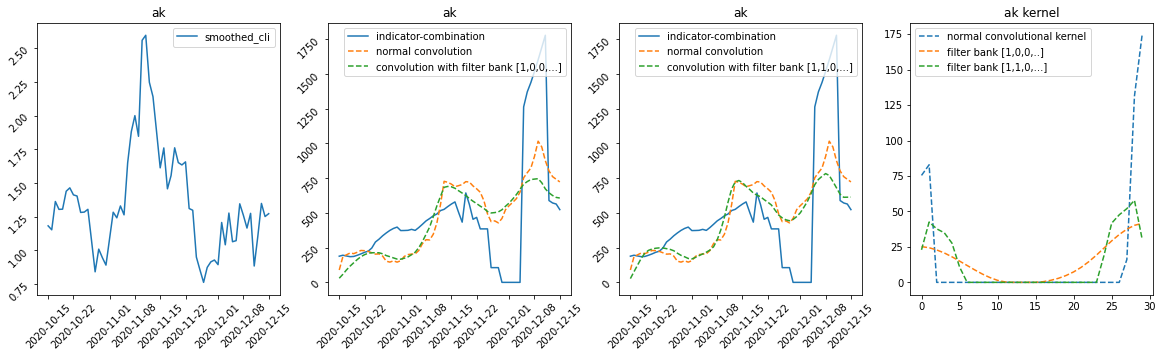

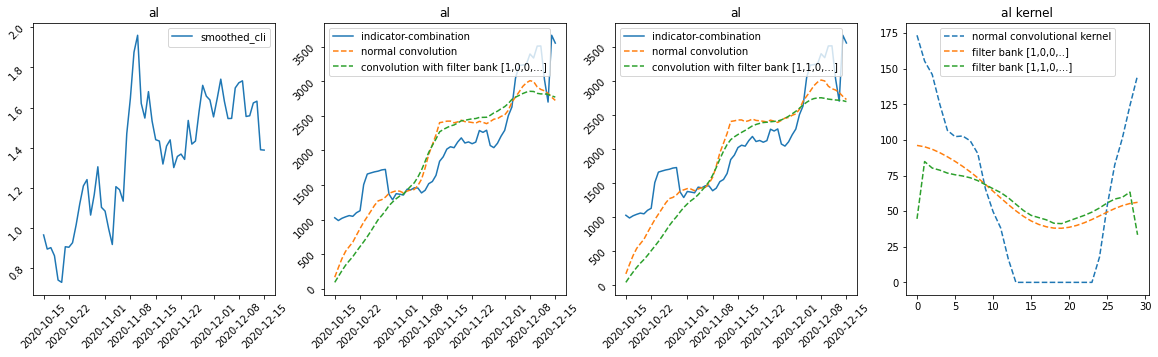

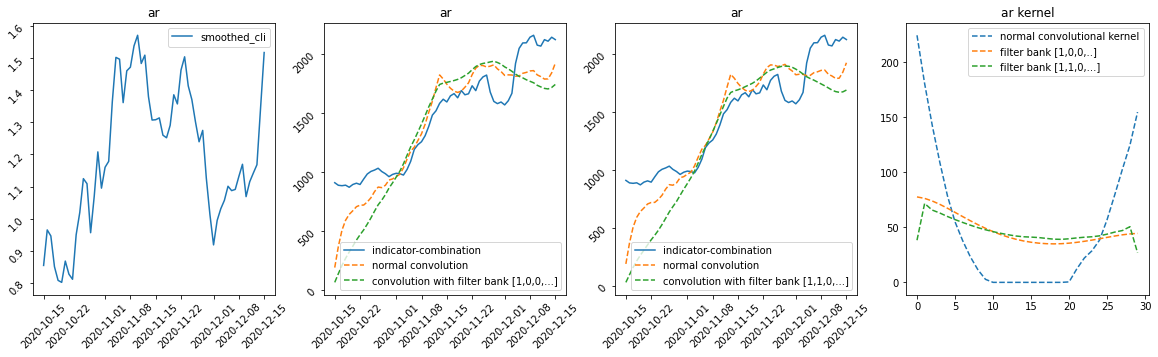

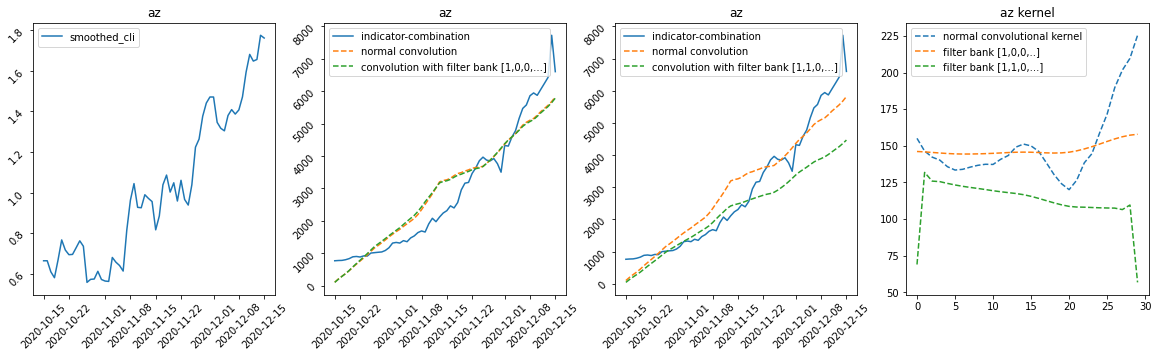

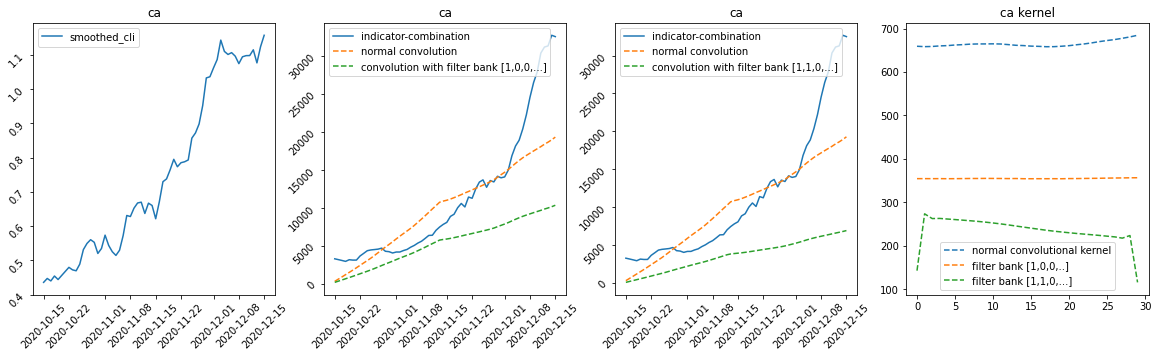

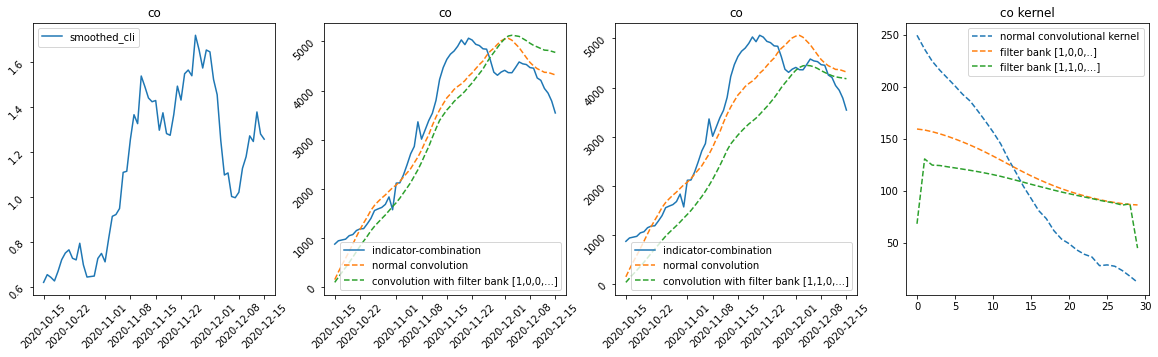

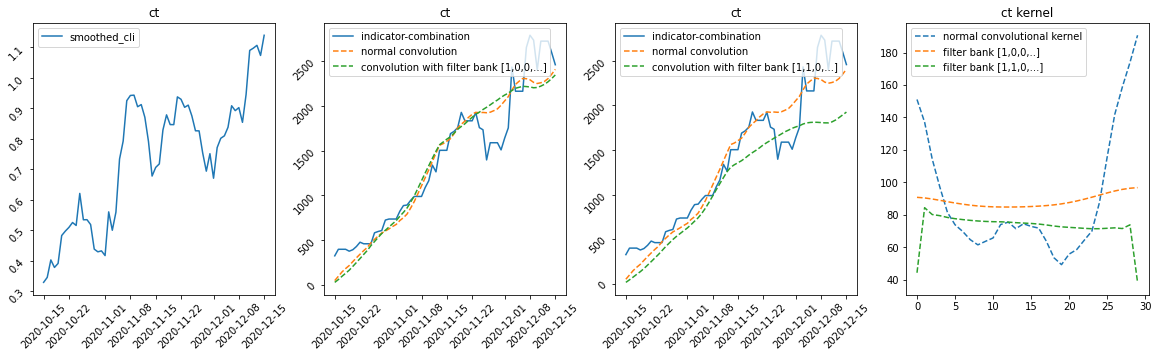

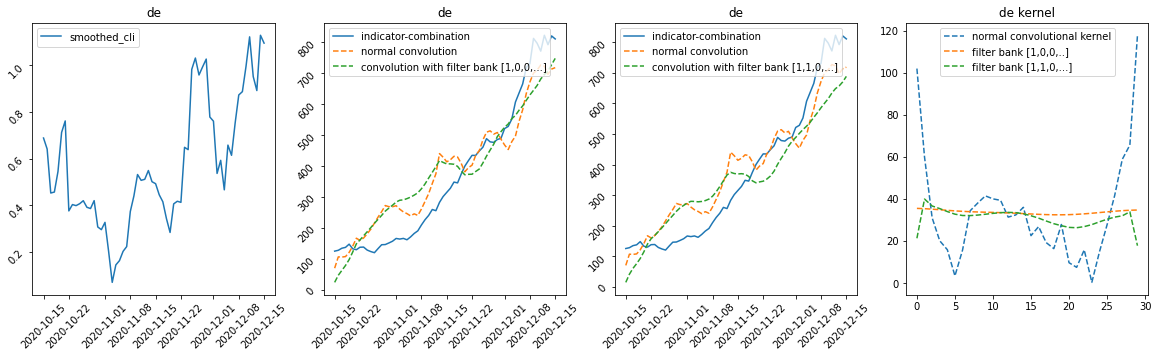

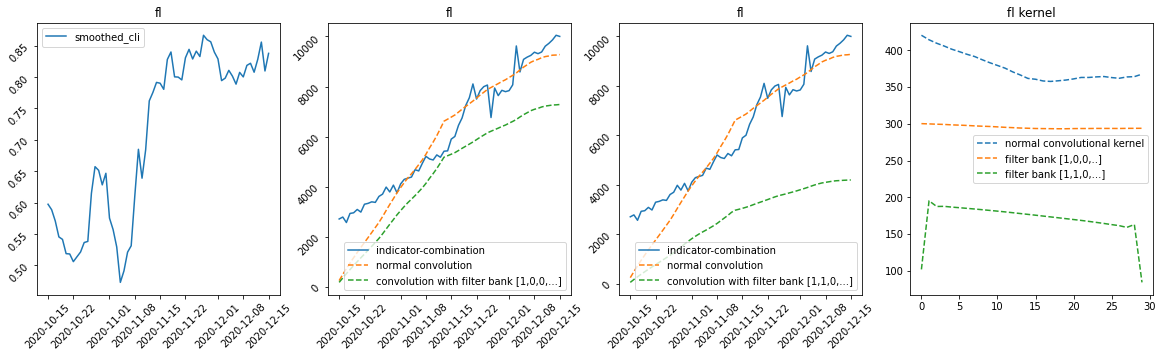

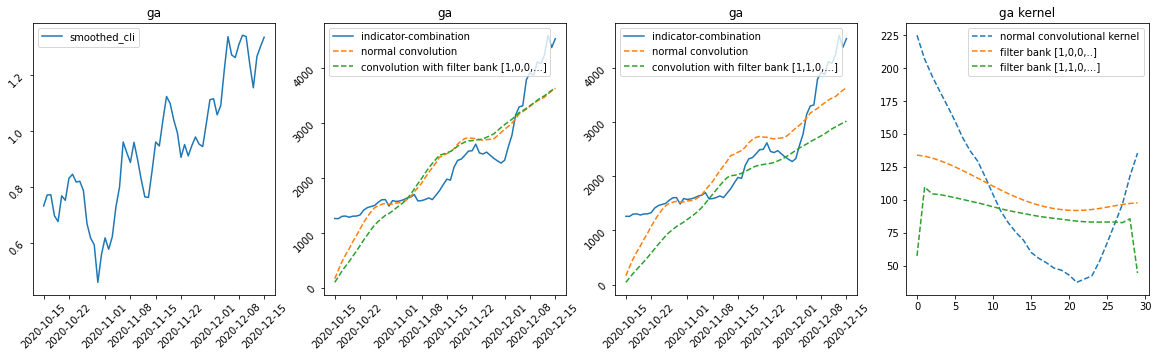

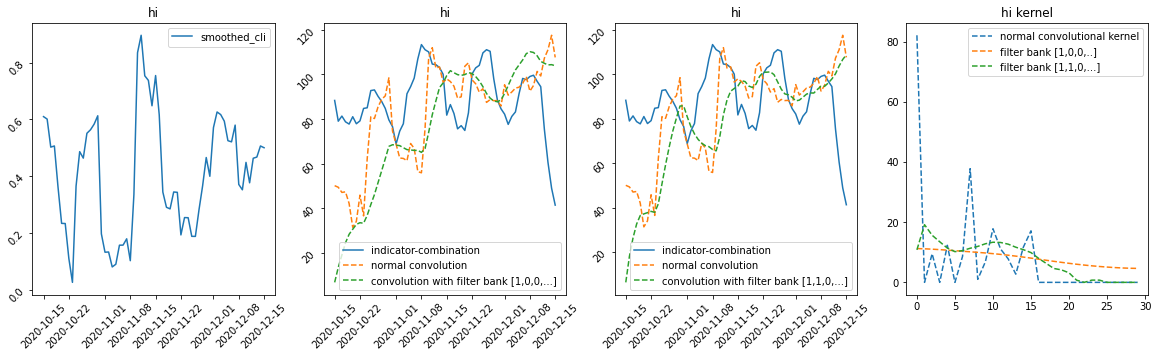

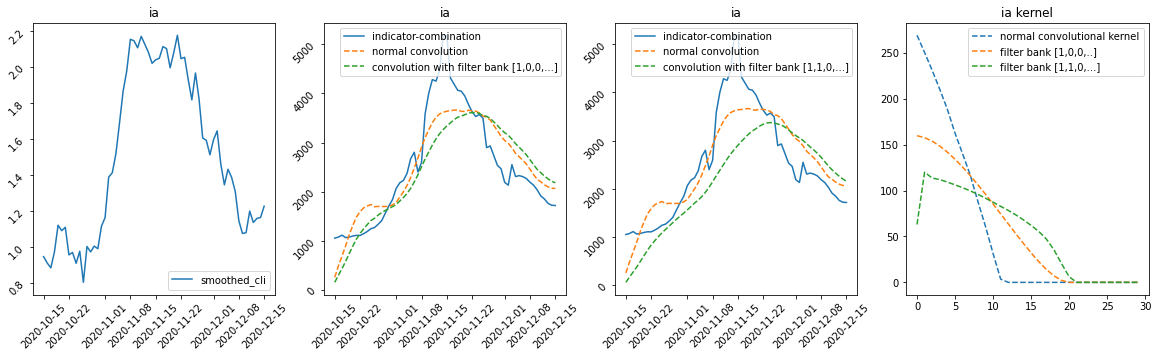

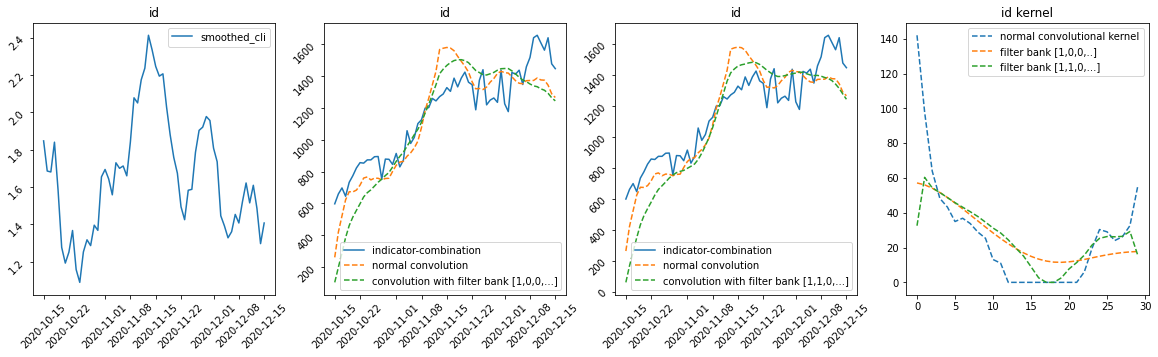

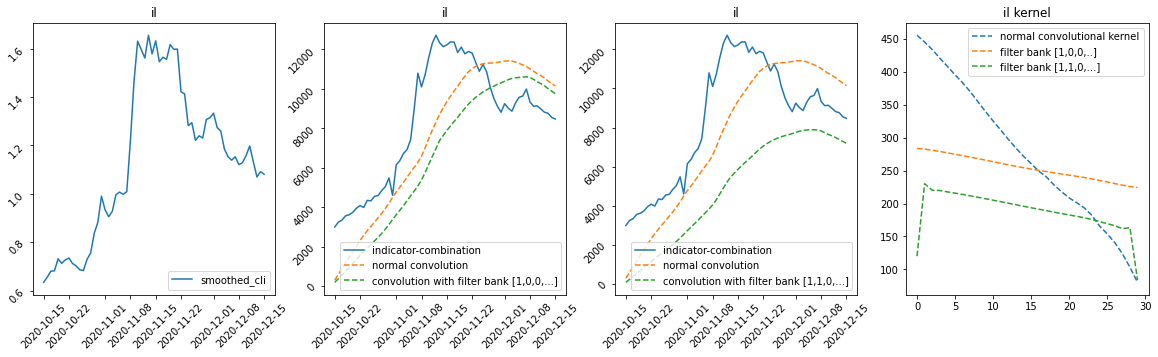

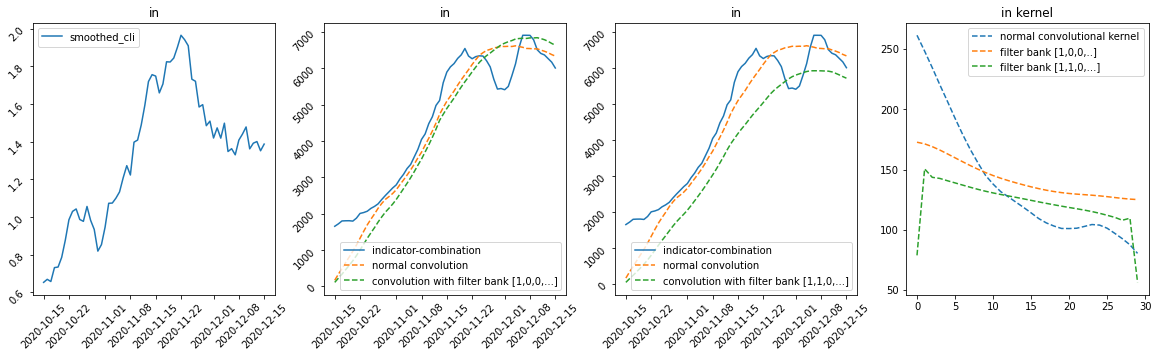

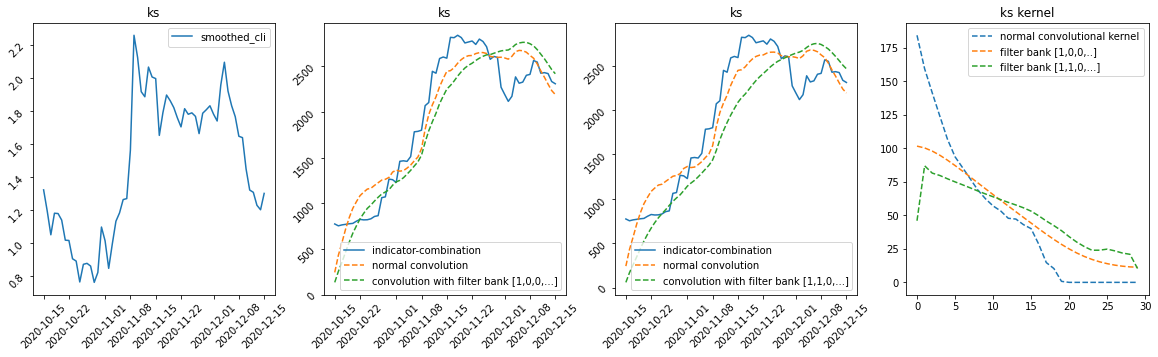

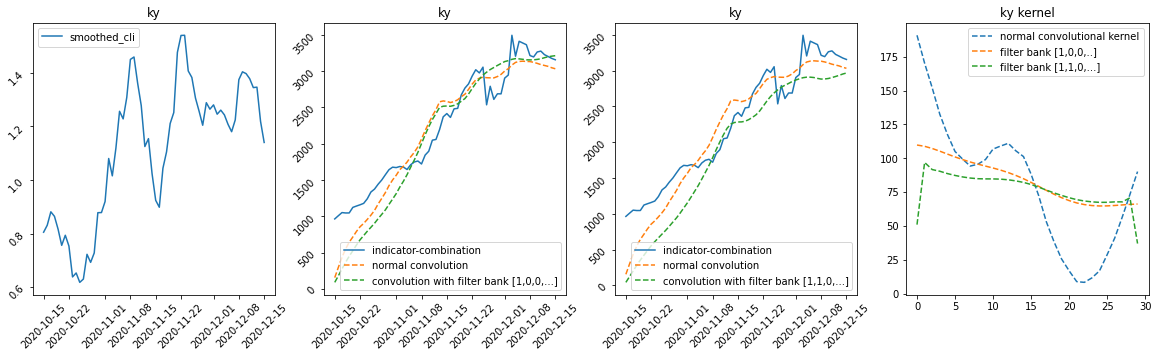

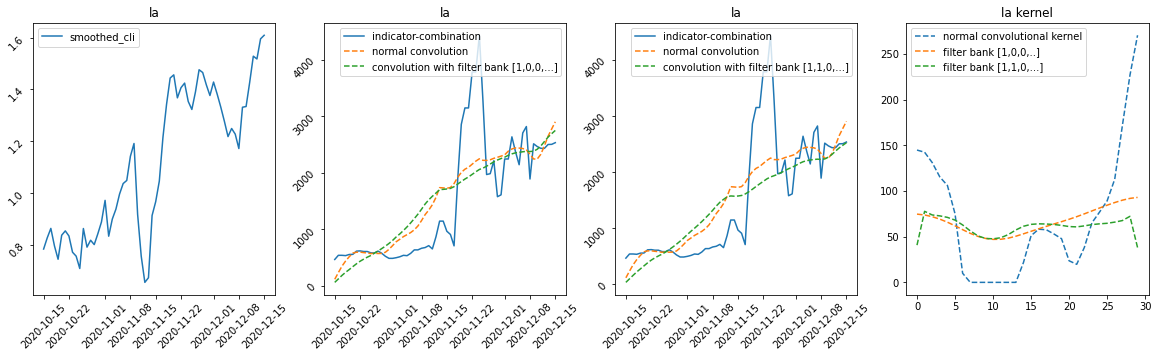

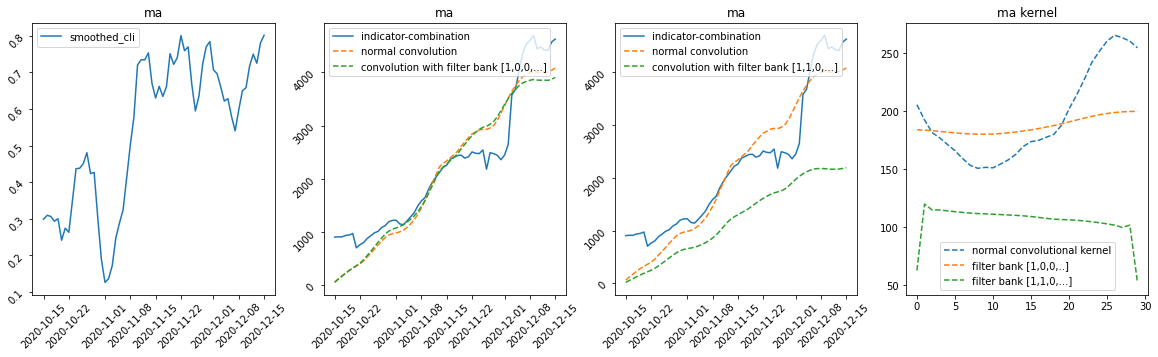

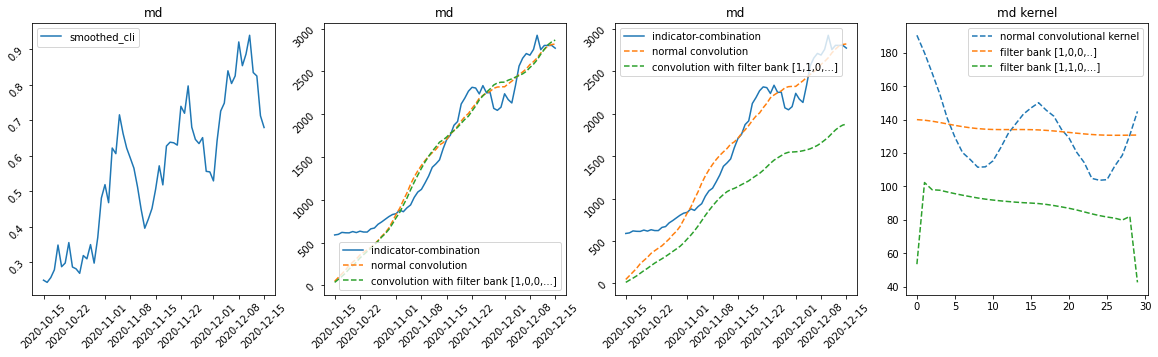

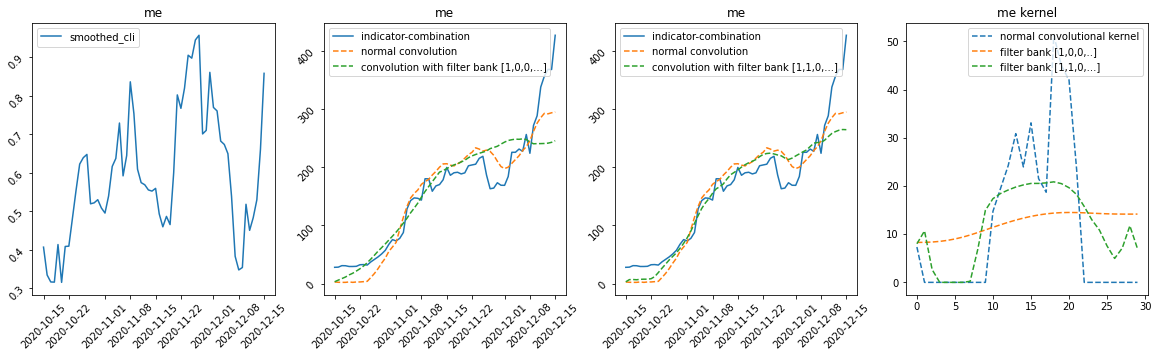

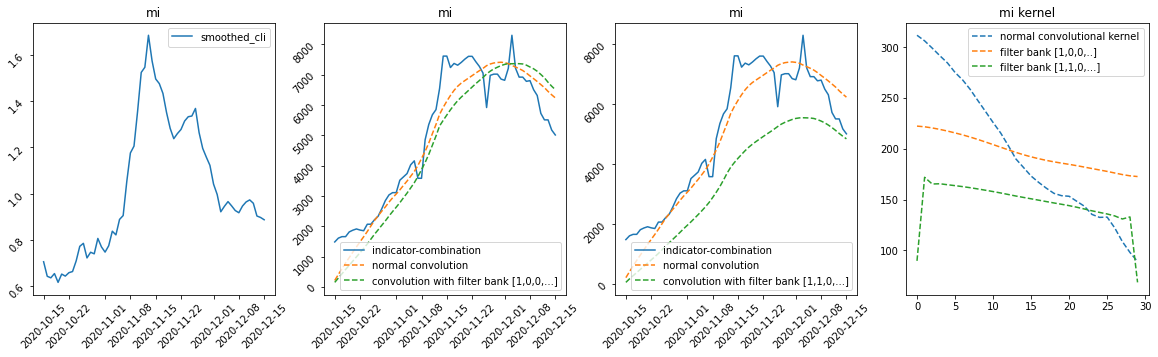

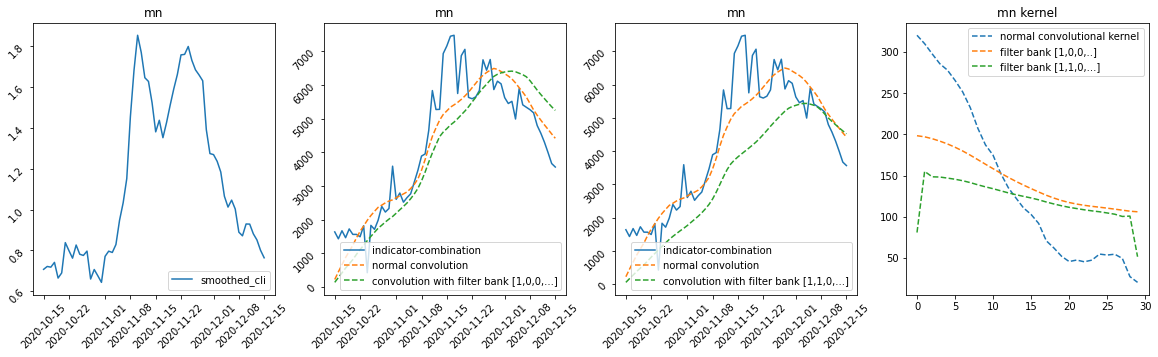

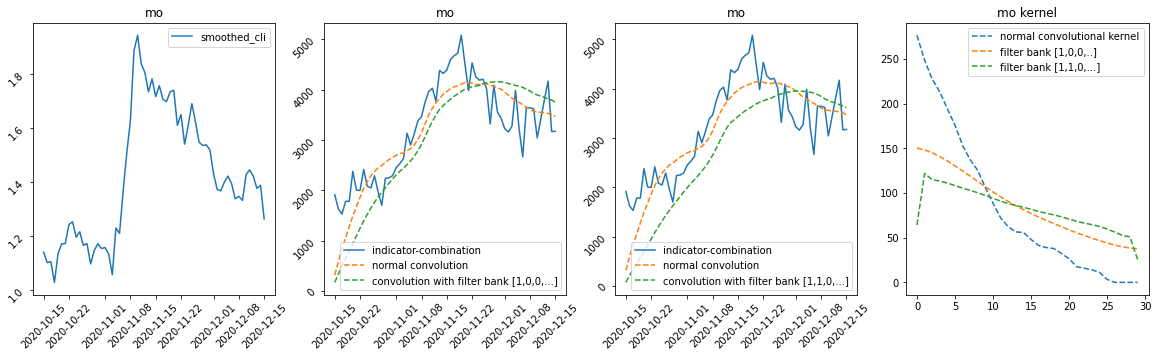

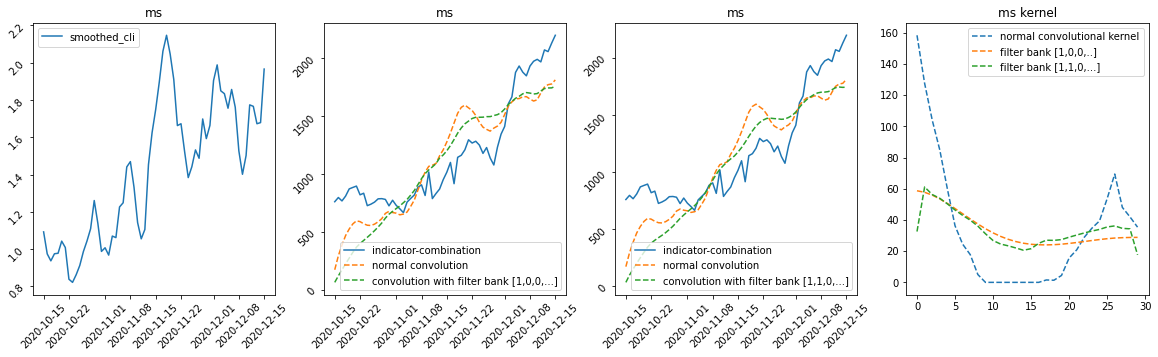

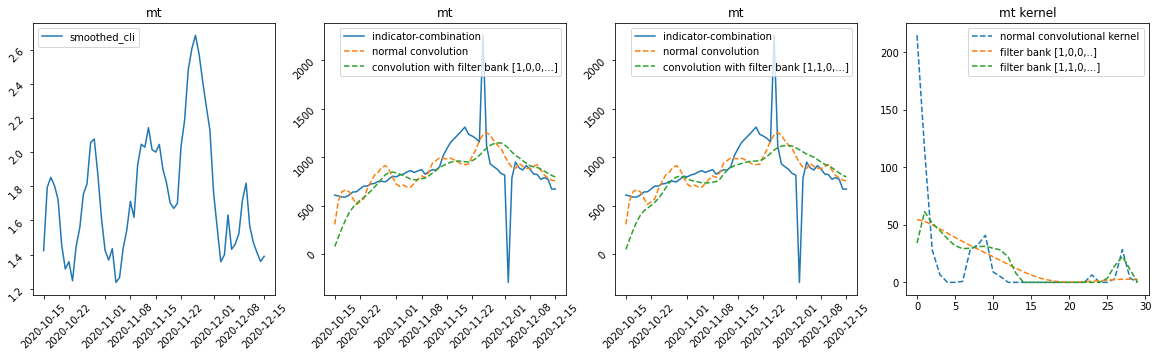

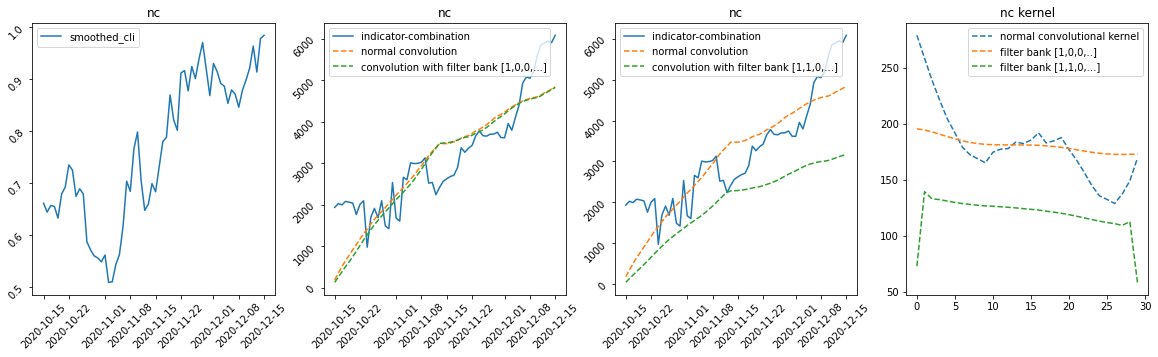

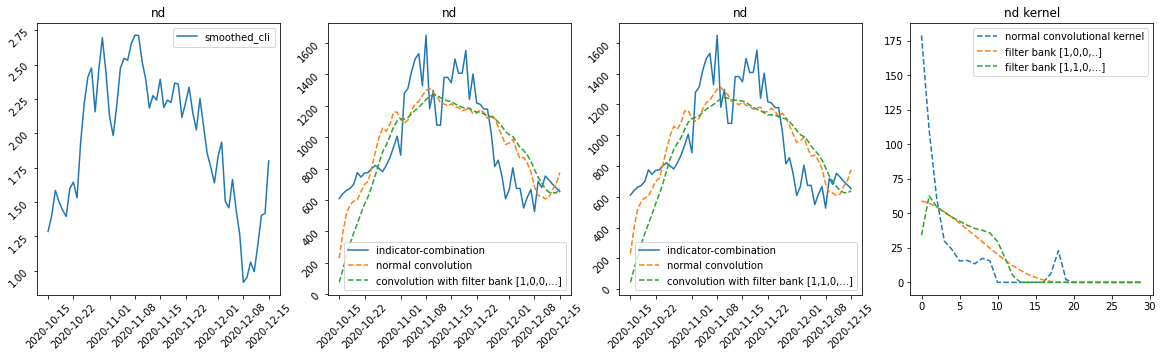

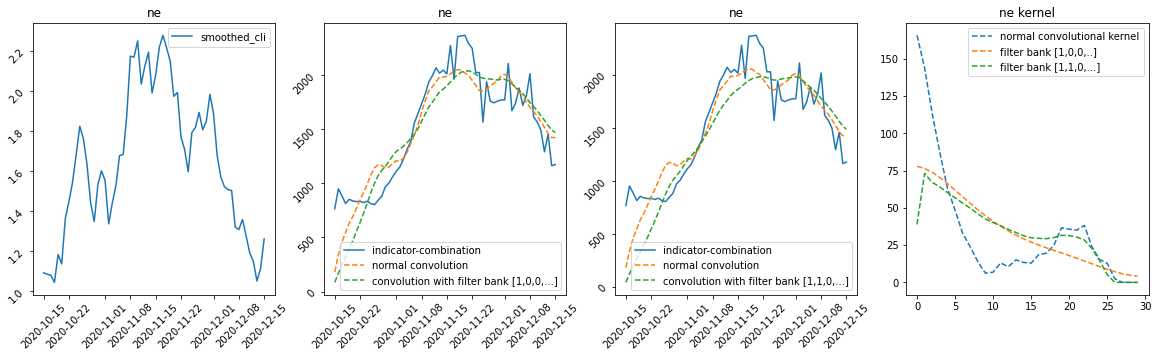

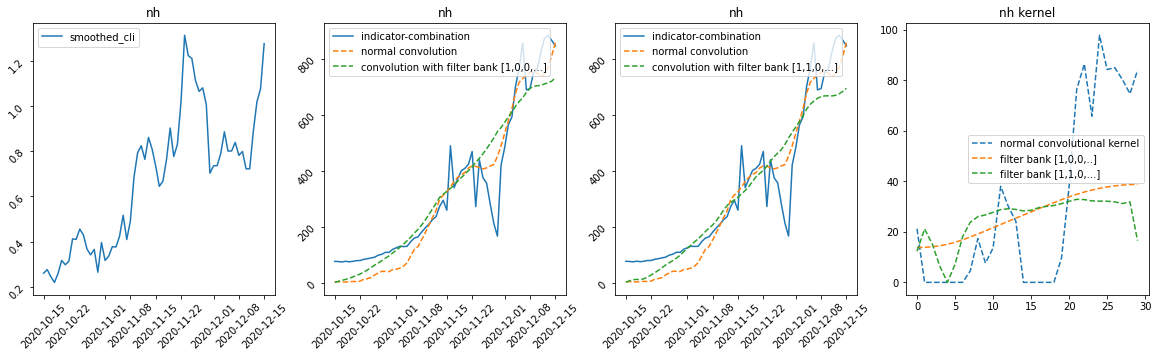

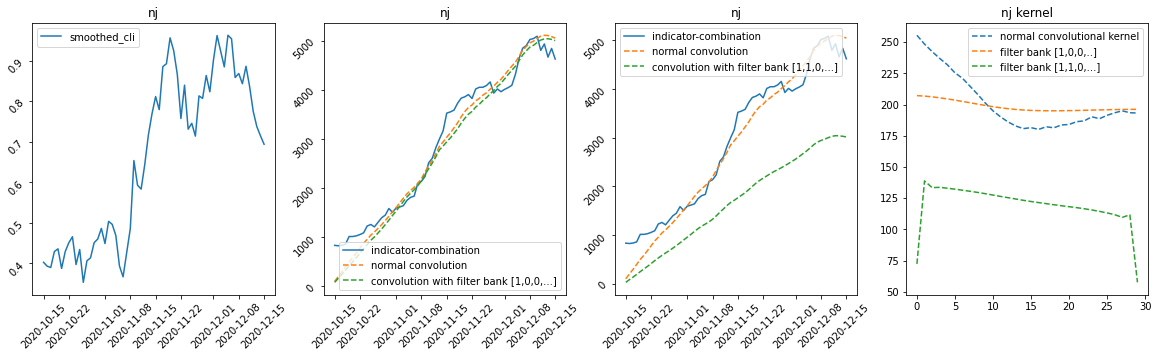

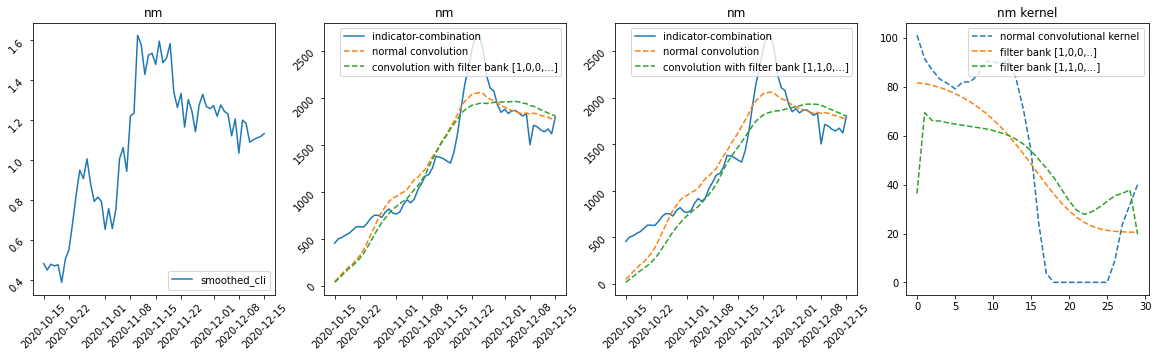

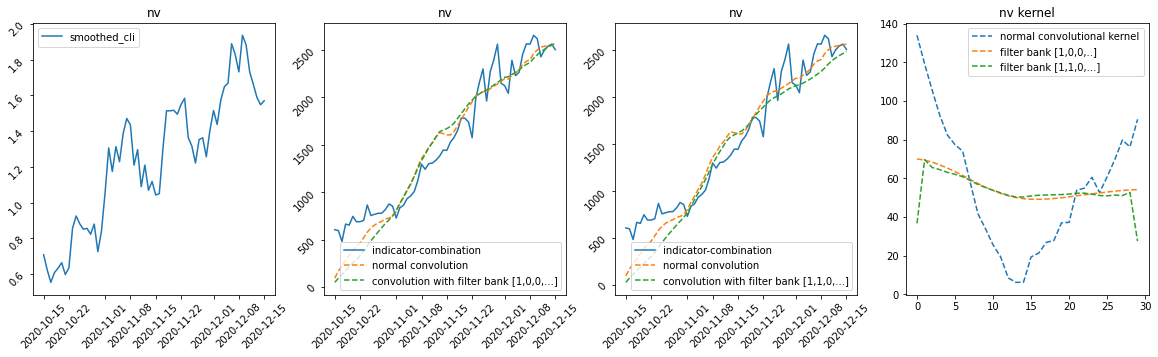

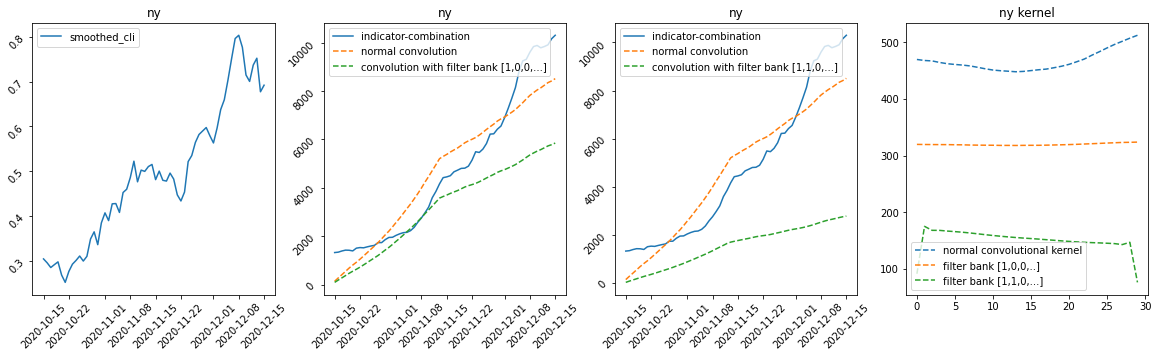

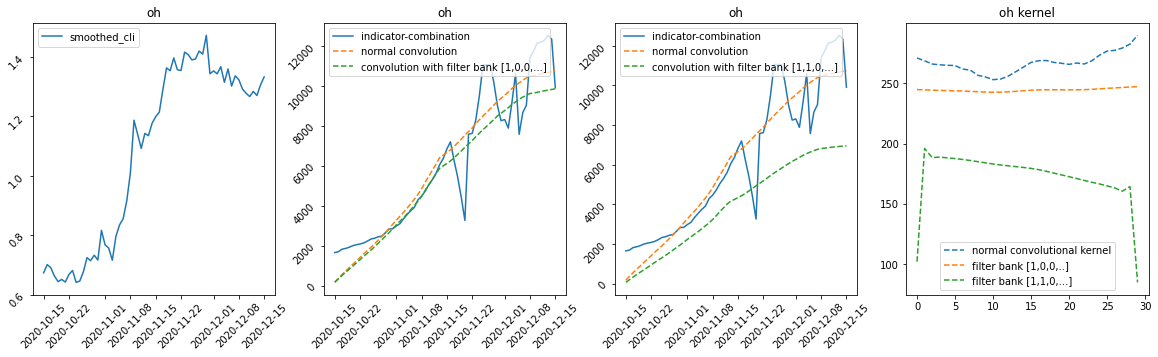

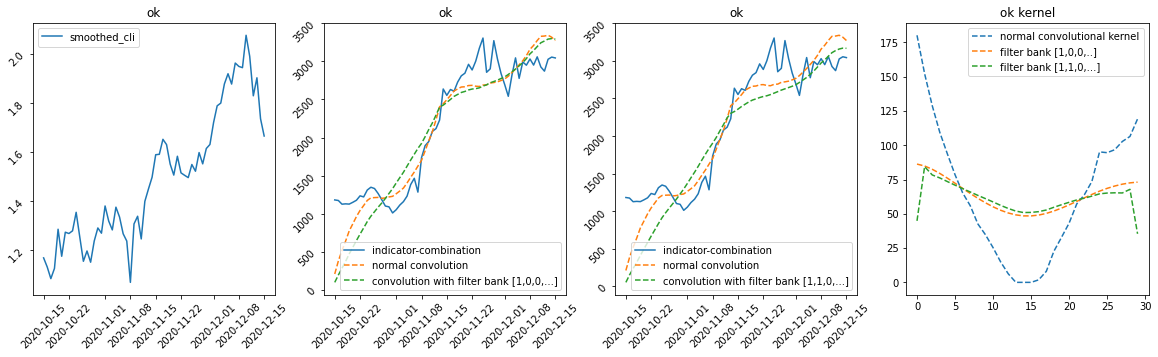

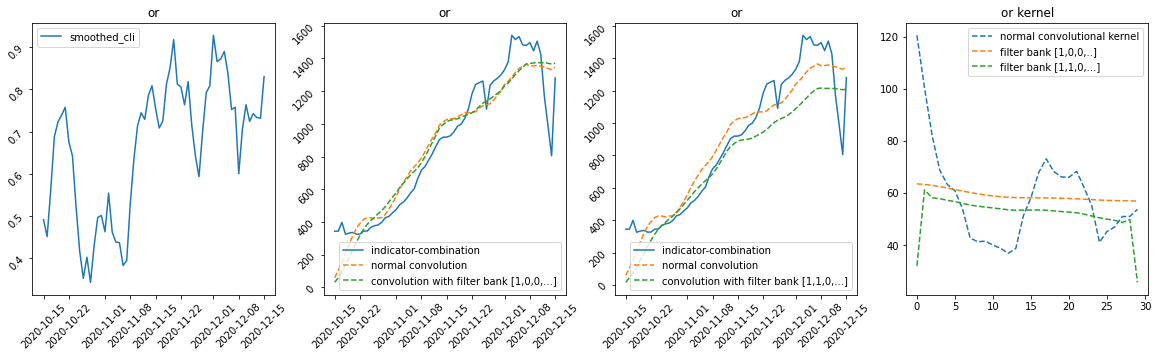

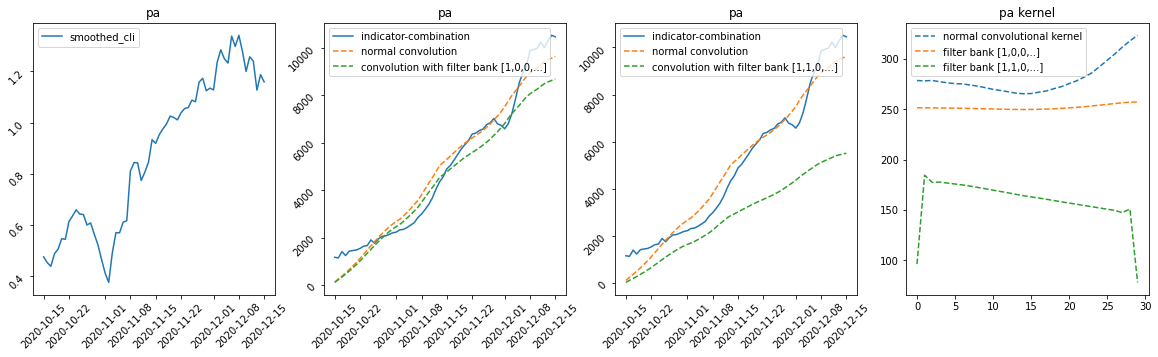

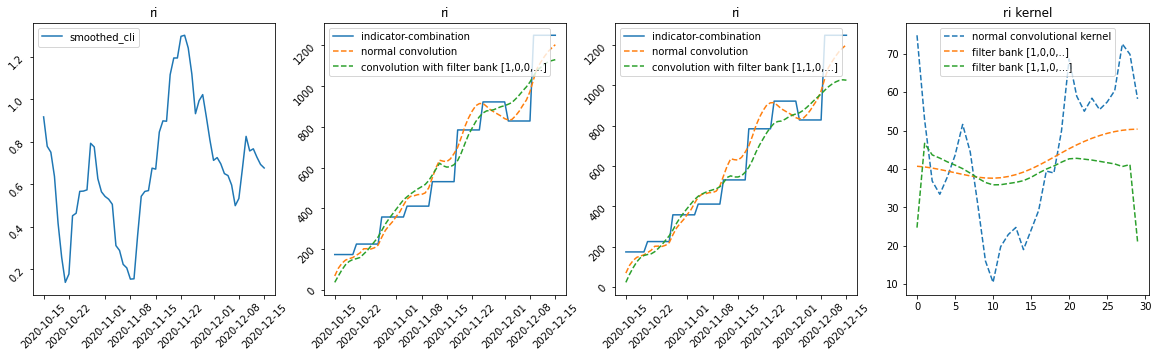

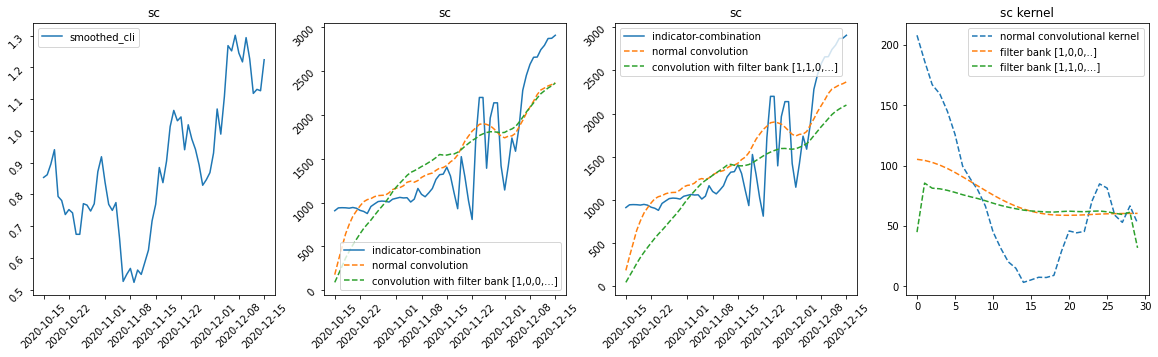

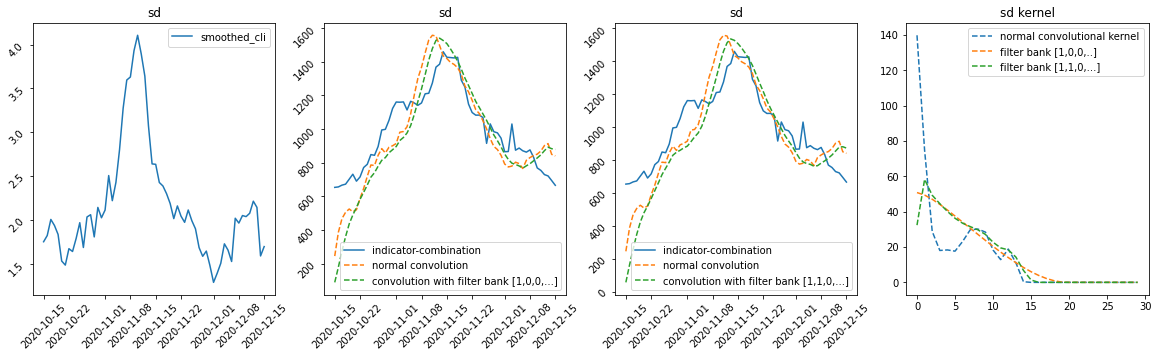

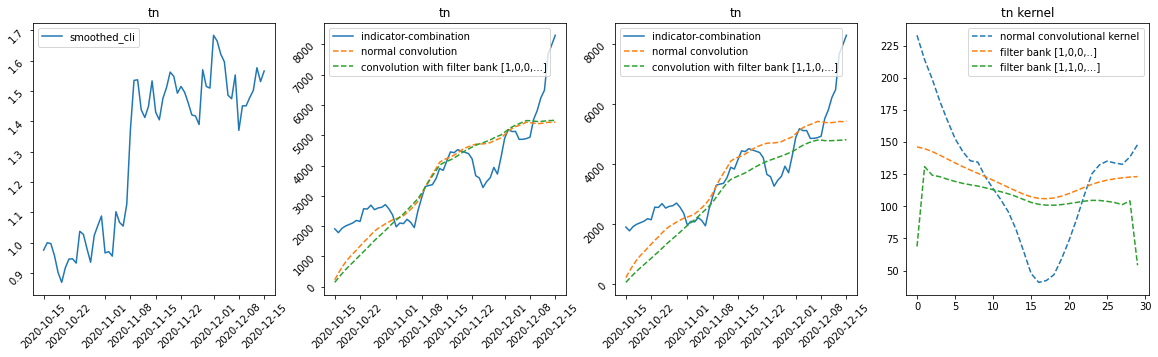

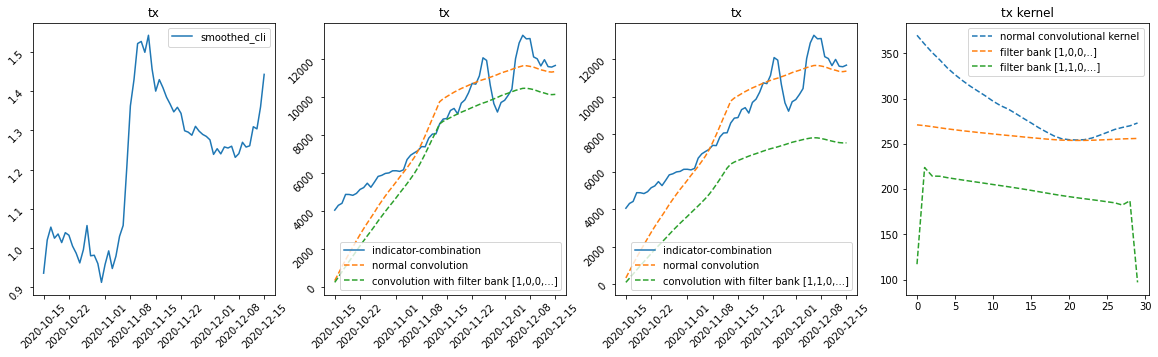

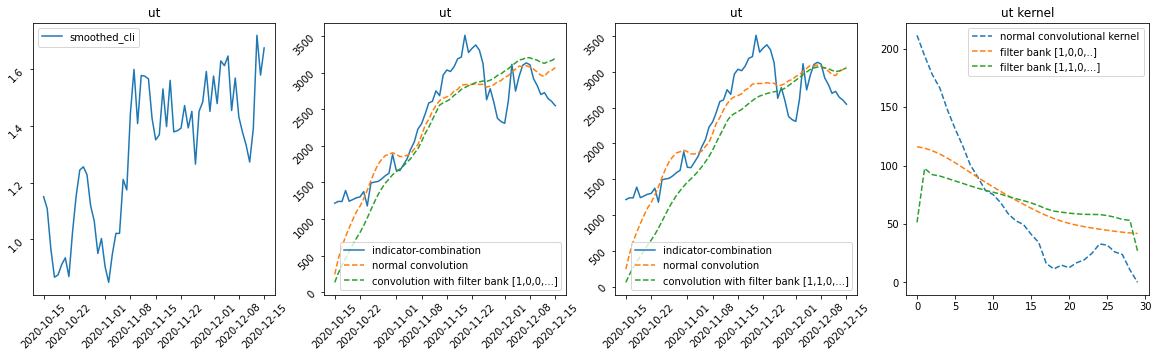

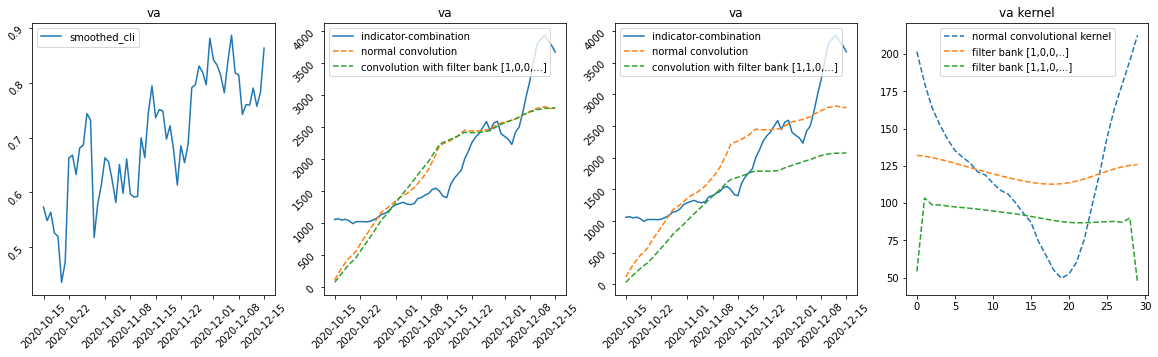

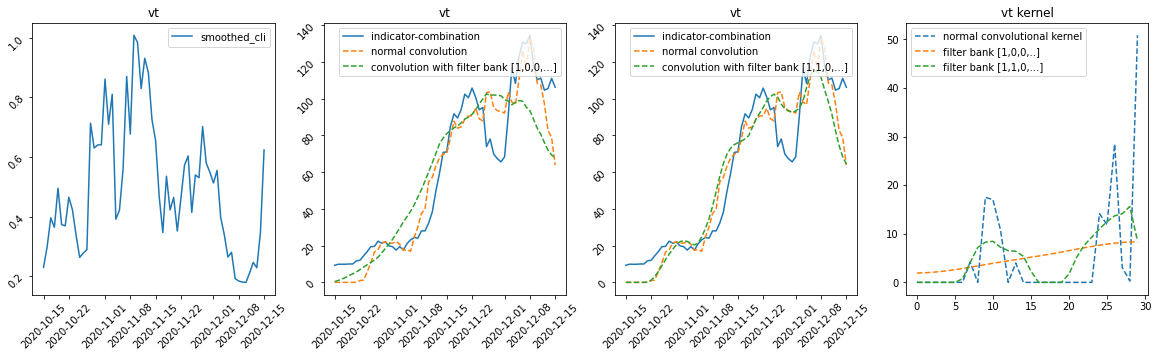

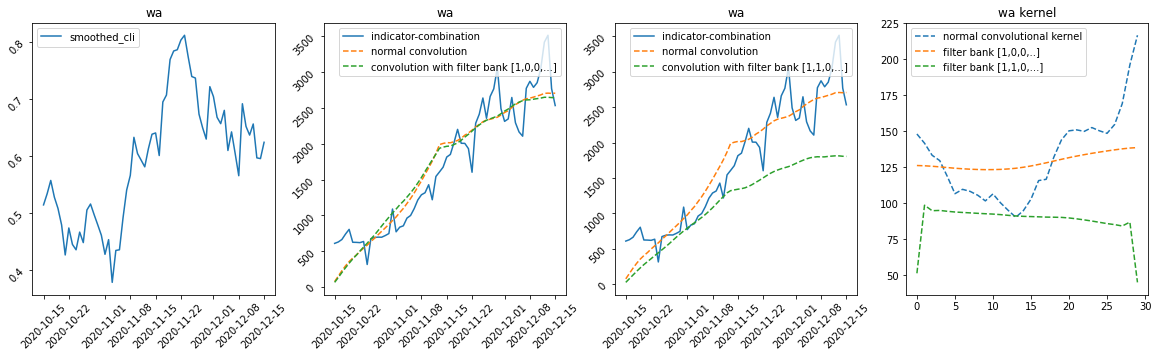

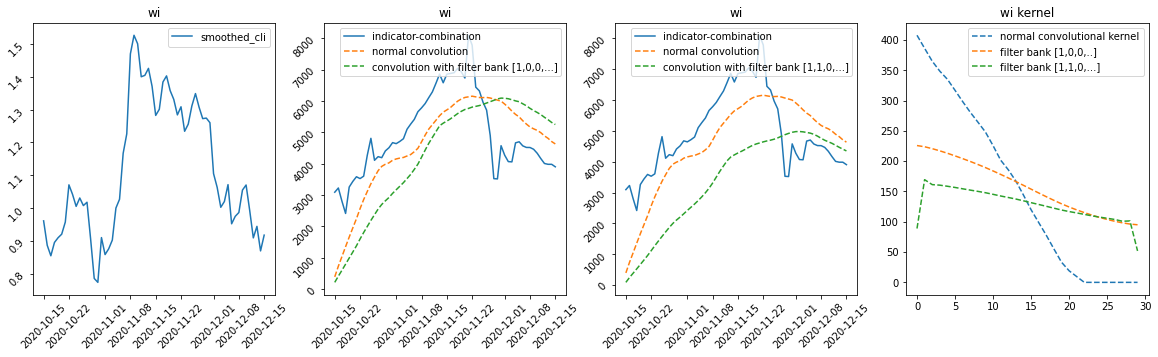

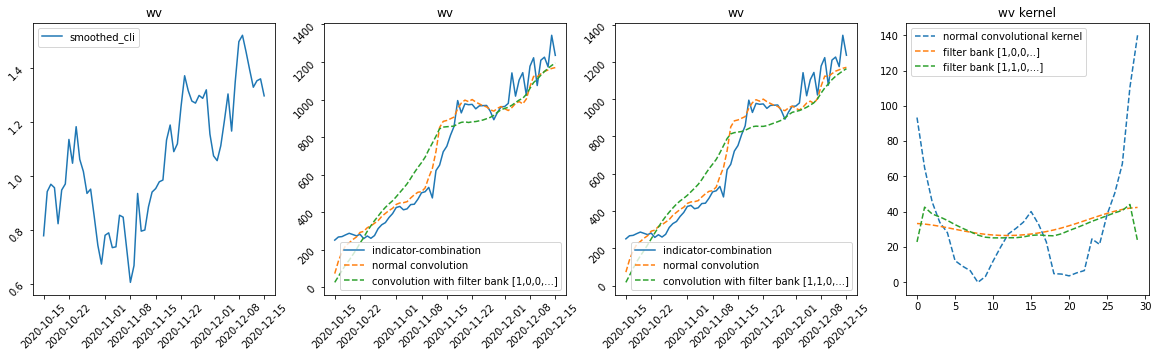

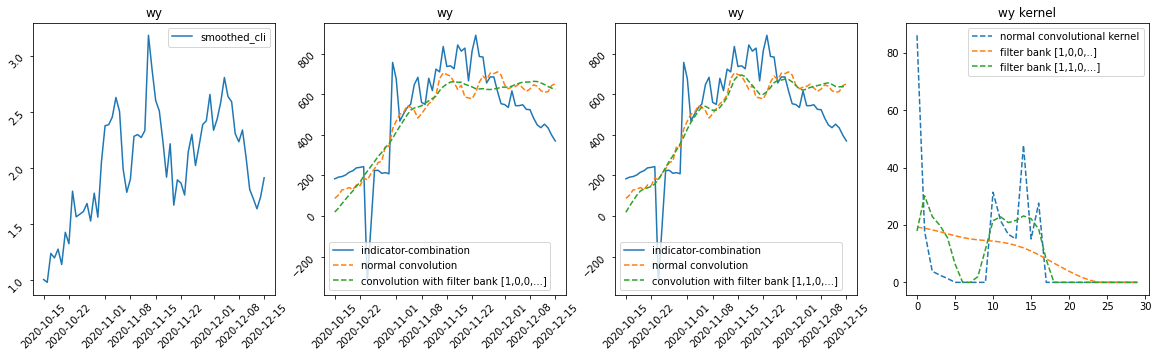

In [39]:
#Evaluation
model_a.load_weights(MODEL_A_PATH).expect_partial() #load best weights from training
model_b.load_weights(MODEL_B_PATH).expect_partial() #load best weights from training
model_c.load_weights(MODEL_C_PATH).expect_partial()

dates = X_df['time_value'].sort_values().unique()
X_padded = tf.pad(
    X[:,:,:],
    paddings=[[0, 0], [p-1, 0], [0, 0]],
)
Y_hat_model_a = model_a(X_padded)
Y_hat_model_b = model_b(X_padded)
Y_hat_model_c = model_c(X_padded)

for i in range(len(states)):
    y = Y_df[Y_df['geo_value']==states[i]]['value']
    x = X_df[X_df['geo_value']==states[i]]['value']
    y_hat_model_a = Y_hat_model_a[0,:,i]
    y_hat_model_b = Y_hat_model_b[0,:,i]
    y_hat_model_c = Y_hat_model_c[0,:,i]
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    ax[0].plot(dates, x, label='smoothed_cli')
    ax[0].legend()
    ax[0].set_title('{}'.format(states[i]))
    ax[0].tick_params(labelrotation=45)
    
    ax[1].plot(dates, y, label='indicator-combination')
    ax[1].plot(dates, y_hat_model_a, label='normal convolution', linestyle='--')
    ax[1].plot(dates, y_hat_model_b, label='convolution with filter bank [1,0,0,...]', linestyle='--')
    ax[1].legend()
    ax[1].set_title('{}'.format(states[i]))
    ax[1].tick_params(labelrotation=45)
    
    ax[2].plot(dates, y, label='indicator-combination')
    ax[2].plot(dates, y_hat_model_a, label='normal convolution', linestyle='--')
    ax[2].plot(dates, y_hat_model_c, label='convolution with filter bank [1,1,0,...]', linestyle='--')
    ax[2].legend()
    ax[2].set_title('{}'.format(states[i]))
    ax[2].tick_params(labelrotation=45)
    
    ax[3].plot(model_a.trainable_variables[i][::-1,0,0], label='normal convolutional kernel', linestyle='--')
    ax[3].plot(get_kernel(model_b,i)[::-1], label='filter bank [1,0,0,..]', linestyle='--')
    ax[3].plot(get_kernel(model_c,i)[::-1], label='filter bank [1,1,0,...]', linestyle='--')
    ax[3].legend()
    ax[3].set_title('{} kernel'.format(states[i]))
    
    plt.show()